In [1]:
!pip -q install medmnist

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 4.8 MB/s eta 0:00:00


In [2]:
import random
import numpy as np
import torch
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F

import copy
from medmnist import INFO
import medmnist
import matplotlib.pyplot as plt

In [3]:
# Seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
# 1) Dataset
DATASET_NAME = "bloodmnist"
info = INFO[DATASET_NAME]
DataClass = getattr(medmnist, info["python_class"])
num_classes = len(info["label"])
num_channels = info["n_channels"]

print("Dataset:", DATASET_NAME)
print("Task:", info["task"])
print("N channels:", num_channels)
print("N classes:", num_classes)
print("Labels:", info["label"])

# 2) Transforms
transform = transforms.ToTensor()   # convert image to tensor of shape (CxHxW) and normalize pixel values: [0,255] ->  [0,1]

# 3) Train/Validation/Test sets
train_dataset = DataClass(split="train", download=True, transform=transform)
val_dataset = DataClass(split="val", download=True, transform=transform)
test_dataset = DataClass(split="test", download=True, transform=transform)

print("Train:", len(train_dataset))
print("Val:", len(val_dataset))
print("Test:", len(test_dataset))

# Έλεγχος ενός δείγματος
x0, y0 = train_dataset[0]
print("Single sample x:", x0.shape, "y:", y0)

# 4) Loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)   # groups data into mini-batches
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

class_names = [info["label"][str(i)] for i in range(num_classes)]

# Έλεγχος ενός batch
xb, yb = next(iter(train_loader))
print("Batch x:", xb.shape, "Batch y:", yb.shape)

Dataset: bloodmnist
Task: multi-class
N channels: 3
N classes: 8
Labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
Train: 11959
Val: 1712
Test: 3421
Single sample x: torch.Size([3, 28, 28]) y: [7]
Batch x: torch.Size([64, 3, 28, 28]) Batch y: torch.Size([64, 1])


Train counts: [ 852 2181 1085 2026  849  993 2330 1643] ,sum = 11959
Val counts:   [122 312 155 290 122 143 333 235] ,sum = 1712
Test counts:  [244 624 311 579 243 284 666 470] ,sum = 3421


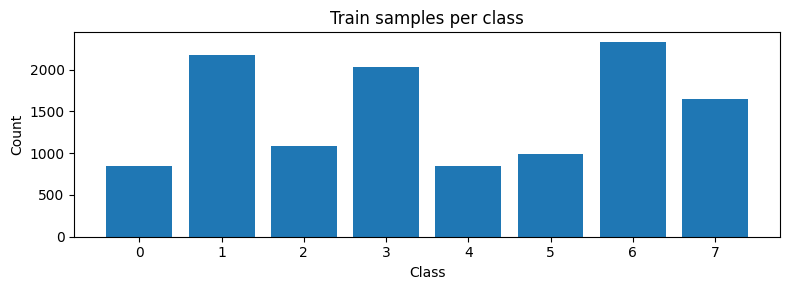

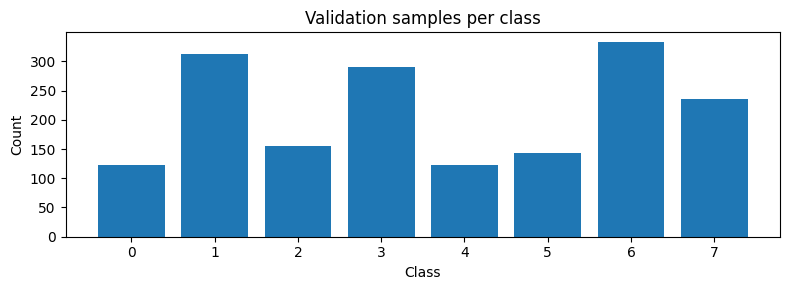

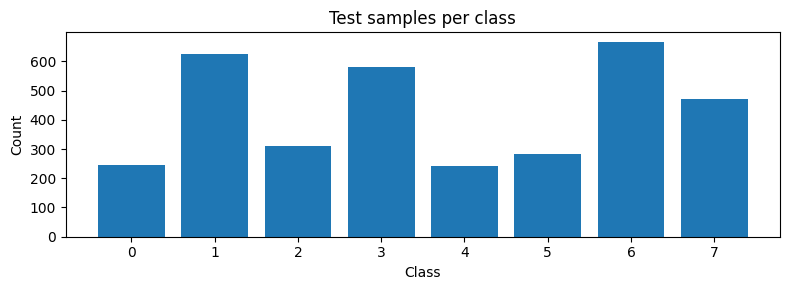

In [8]:
# Counts samples per class on a dataset
def count_classes(ds, num_classes):
    counts = np.zeros(num_classes, dtype=int)
    for _, y in ds:
        label = int(y.item()) if hasattr(y, "item") else int(y)
        counts[label] += 1
    return counts

num_classes = len(info["label"])
train_counts = count_classes(train_dataset, num_classes)
val_counts   = count_classes(val_dataset, num_classes)
test_counts  = count_classes(test_dataset, num_classes)

print("Train counts:", train_counts, ",sum =", train_counts.sum())
print("Val counts:  ", val_counts,   ",sum =", val_counts.sum())
print("Test counts: ", test_counts,  ",sum =", test_counts.sum())

# Bar Plots
# Train Samples per Class
plt.figure(figsize=(8, 3))
plt.bar(np.arange(num_classes), train_counts)
plt.title("Train samples per class")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Validation Samples per Class
plt.figure(figsize=(8, 3))
plt.bar(np.arange(num_classes), val_counts)
plt.title("Validation samples per class")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Train Samples per Class
plt.figure(figsize=(8, 3))
plt.bar(np.arange(num_classes), test_counts)
plt.title("Test samples per class")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

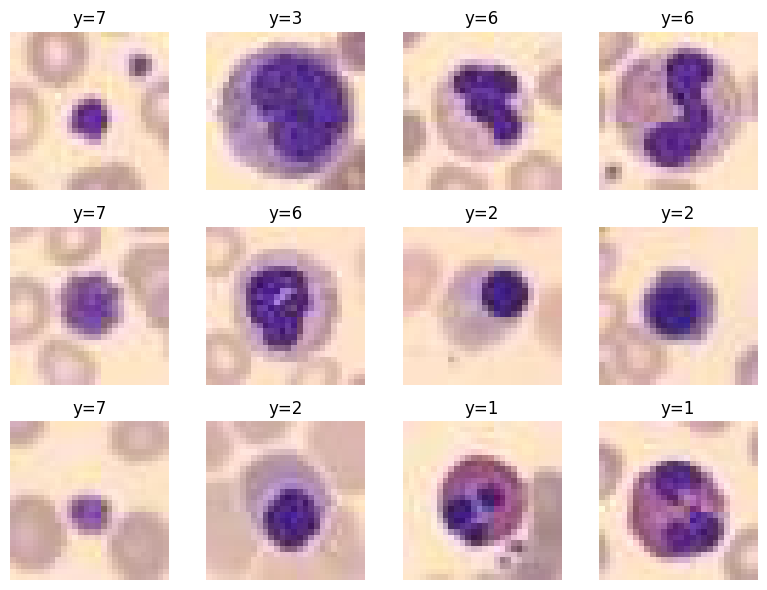

In [ ]:
# Visualise Data
plt.figure(figsize=(8, 6))

for i in range(12):
    x, y = train_dataset[i]

    # [3, H, W] -> [H, W, 3]
    x = x.permute(1, 2, 0)

    y = int(y.item()) if hasattr(y, "item") else int(y[0])

    plt.subplot(3, 4, i + 1)
    plt.imshow(x)
    plt.title(f"y={y}")
    plt.axis("off")

plt.tight_layout()
plt.show()



In [5]:
def accuracy_from_logits(logits, y):
    # logits: raw model outputs, shape [B, num_classes]
    # y: class labels, shape [B] or [B, 1]
    # Returns: accuracy of the batch as a float in [0, 1]

    # Convert [B,1] labels to [B]
    if y.ndim == 2:
        y = y.squeeze(1)

    # Predicted class = index of the largest logit
    preds = torch.argmax(logits, dim=1)

    # Count correct predictions
    correct = (preds == y).sum().item()

    return correct / y.size(0)

def run_one_epoch(model, loader, optimizer=None, device="cpu"):
    # Runs one full epoch over the data loader
    # Forward pass and backpropagation
    # If you are given optimizer -> training mode
    # If optimizer is None -> evaluation mode (validation/test)

    is_train = optimizer is not None

    # Get in training mode for training, or evaluation mode for validation/test sets (No Dropout and frozen Batch Norm parameters)
    if is_train:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    total_acc = 0.0
    total_samples = 0

    criterion = nn.CrossEntropyLoss()

    for x, y in loader:
        # Move data to device (CPU or GPU)
        x = x.to(device)
        y = y.to(device)
        if y.ndim == 2:
            y = y.squeeze(1)

        batch_size = x.size(0)

        if is_train:
            # Training step: forward pass + backward pass + weight update (optimizer)
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            acc = accuracy_from_logits(logits, y)
            loss.backward()       # Backward pass (backpropagation)
            optimizer.step()      # Updates weights

        else:
            # Evaluation step: forward only (no backprop)
            with torch.no_grad():
                logits = model(x)
                loss = criterion(logits, y)
                acc = accuracy_from_logits(logits, y)

        # Accumulate weighted sums for epoch averages
        # loss.item(): (Sum of per-sample losses)/(batch_size)=1/N*ΣL(xi)
        # loss.item()*batch = sum of per-sample losses = ΣL(xi)
        # total_loss = ΣL(x_i)_batch1 + ΣL(x_i)_batch2 + ...
        total_loss += loss.item() * batch_size
        total_acc  += acc * batch_size
        total_samples += batch_size

    # mean loss over the entire epoch = (total_loss)/N
    # mean accuracy over the entire epoch
    return total_loss / total_samples, total_acc / total_samples


class EarlyStopping:
    # Stops training when validation loss stops improving

    def __init__(self, patience):
      # patience: number of epochs to wait without improvement
        self.patience = patience
        self.best_val_loss = float("inf")
        self.best_state_dict = None
        self.best_epoch = None
        self.counter = 0

    def step(self, model, val_loss, epoch):
        # Checks if validation loss improved
        # Saves model weights if this is the best epoch so far

        if val_loss < self.best_val_loss:      # if val_loss improved
            self.best_val_loss = val_loss     # best val_loss so far is the current val_loss
            self.best_state_dict = copy.deepcopy(model.state_dict())    # keeps best state (parameters)
                                                                        # self.best_state_dict=model.state_dict() is wrong best_state will keep the current state(weights) of the model
            self.best_epoch = epoch     # best epoch so far is the current epoch
            self.counter = 0        # val_loss improved, set count to 0
            return False
        else:
            self.counter += 1       # val_loss diodn't improve, increase count by 1
            # return true if number of epochs with no improvement > patience
            return self.counter >= self.patience

    def restore_best_weights(self, model):
        # Loads the best saved weights back into the model
        if self.best_state_dict is not None:
            model.load_state_dict(self.best_state_dict)



def train_model(model, train_loader, val_loader, epochs, device, optimizer, patience):
    # Full training loop with validation and early stopping

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    # Early Stopping object
    early_stopper = EarlyStopping(patience)

    # Flag to print the final print message
    stopped_early = False

    for epoch in range(1, epochs + 1):
        # Training loop
        train_loss, train_acc = run_one_epoch(model, train_loader, optimizer, device)

        # Evaluation loop on validation set (inference-evaluation mode)
        val_loss, val_acc = run_one_epoch(model, val_loader, None, device)

        # Save epoch metrics (train acc/loss, val acc/loss) on a list
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # Print epoch metrics
        print(f"Epoch {epoch:02d}/{epochs} | " f"Train acc: {train_acc:.4f} - Train loss: {train_loss:.4f} | " f"Val acc: {val_acc:.4f} - Val loss: {val_loss:.4f}")

        # Stop training if validation loss does not improve
        if early_stopper.step(model, val_loss, epoch):
            print(f"\nEarly stopping triggered at epoch: {epoch}. " f"Best epoch: {early_stopper.best_epoch}")
            stopped_early = True
            break

    # Use model with best weights
    early_stopper.restore_best_weights(model)

    # All epochs were completed
    if not stopped_early:
        print(f"\nTraining finished. " f"Best epoch: {early_stopper.best_epoch}")

    return history

# **Model 1 - Baseline Model**

In [ ]:
class CNN_Model1(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        # Block 1: 32 filters
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2)  # 28 -> 14

        # Block 2: 64 filters
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2)  # 14 -> 7

        # Block 3: 128 filters
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2)  # 7 -> 3

        # Υπολογιζουμε το flatten size:
        # input 28x28 -> after 3 pools (x2): 28->14->7->3
        self.flatten_dim = 128 * 3 * 3

        # Classifier head (dense)
        self.fc = nn.Linear(self.flatten_dim, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))

        x = x.reshape(x.size(0), -1)
        x = self.fc(x)                # logits
        return x


In [ ]:
model1 = CNN_Model1(in_channels=num_channels, num_classes=num_classes).to(device)
optimizer = torch.optim.Adam(model1.parameters(), lr=1e-3)
hist = train_model(model1, train_loader, val_loader, epochs=30, device=device, optimizer=optimizer, patience=5)

Epoch 01/30 | Train acc: 0.5691 - Train loss: 1.1538 | Val acc: 0.7482 - Val loss: 0.7383
Epoch 02/30 | Train acc: 0.7626 - Train loss: 0.6570 | Val acc: 0.8049 - Val loss: 0.5257
Epoch 03/30 | Train acc: 0.8178 - Train loss: 0.5116 | Val acc: 0.8067 - Val loss: 0.5042
Epoch 04/30 | Train acc: 0.8450 - Train loss: 0.4398 | Val acc: 0.8540 - Val loss: 0.4067
Epoch 05/30 | Train acc: 0.8602 - Train loss: 0.3918 | Val acc: 0.8464 - Val loss: 0.4308
Epoch 06/30 | Train acc: 0.8731 - Train loss: 0.3592 | Val acc: 0.8779 - Val loss: 0.3395
Epoch 07/30 | Train acc: 0.8764 - Train loss: 0.3438 | Val acc: 0.8849 - Val loss: 0.3305
Epoch 08/30 | Train acc: 0.8863 - Train loss: 0.3161 | Val acc: 0.8639 - Val loss: 0.3867
Epoch 09/30 | Train acc: 0.8924 - Train loss: 0.2986 | Val acc: 0.8896 - Val loss: 0.3039
Epoch 10/30 | Train acc: 0.8983 - Train loss: 0.2866 | Val acc: 0.8989 - Val loss: 0.2890
Epoch 11/30 | Train acc: 0.9101 - Train loss: 0.2517 | Val acc: 0.8995 - Val loss: 0.2810
Epoch 12/3

Πολυ καλη αποδοση χωρις καμια εφαρμογη τεχνικης, που σημαινει οτι με αυτη την αρχιτεκτονικη, το dataset που διαλεξα ειναι ευκολο για το CNN μου.

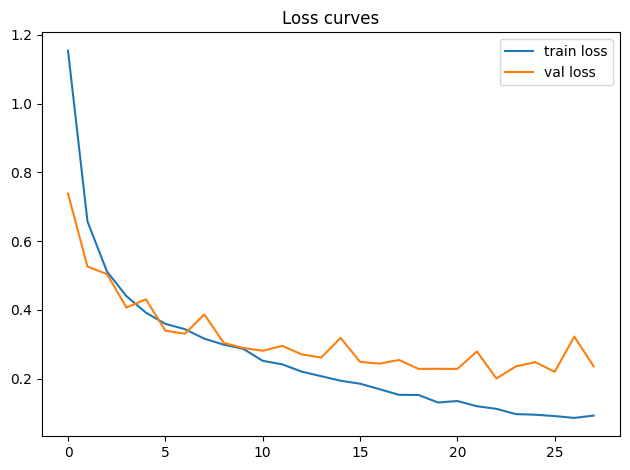

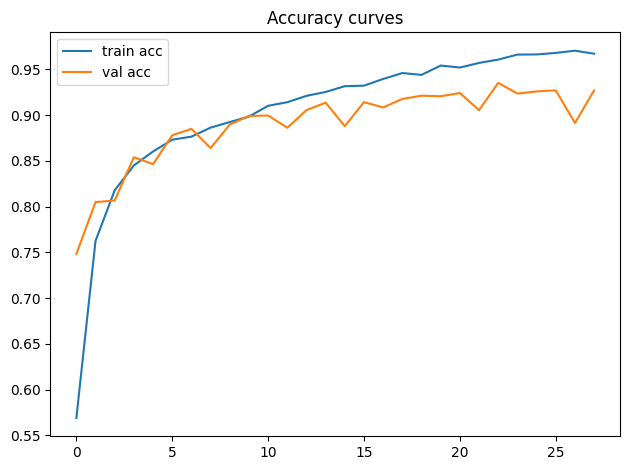

In [ ]:
plt.figure()
plt.plot(hist["train_loss"], label="train loss")
plt.plot(hist["val_loss"], label="val loss")
plt.legend()
plt.title("Loss curves")
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(hist["train_acc"], label="train acc")
plt.plot(hist["val_acc"], label="val acc")
plt.legend()
plt.title("Accuracy curves")
plt.tight_layout()
plt.show()


# **Model 2 - Baseline + Batch Normalization**

In [ ]:
class CNN_Model2_BN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2)

        self.flatten_dim = 128 * 3 * 3
        self.fc = nn.Linear(self.flatten_dim, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))

        x = x.reshape(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
model2 = CNN_Model2_BN(num_channels, num_classes).to(device)
optimizer = torch.optim.Adam(model2.parameters(), lr=5e-4)
hist2 = train_model(model2, train_loader, val_loader, epochs=30, device=device, optimizer=optimizer, patience = 5)

Epoch 01/30 | Train acc: 0.8014 - Train loss: 0.5734 | Val acc: 0.8645 - Val loss: 0.3886
Epoch 02/30 | Train acc: 0.8908 - Train loss: 0.3110 | Val acc: 0.8908 - Val loss: 0.3008
Epoch 03/30 | Train acc: 0.9211 - Train loss: 0.2339 | Val acc: 0.8703 - Val loss: 0.3612
Epoch 04/30 | Train acc: 0.9367 - Train loss: 0.1898 | Val acc: 0.9071 - Val loss: 0.2521
Epoch 05/30 | Train acc: 0.9499 - Train loss: 0.1556 | Val acc: 0.9322 - Val loss: 0.1956
Epoch 06/30 | Train acc: 0.9590 - Train loss: 0.1272 | Val acc: 0.9030 - Val loss: 0.2684
Epoch 07/30 | Train acc: 0.9634 - Train loss: 0.1116 | Val acc: 0.9182 - Val loss: 0.2386
Epoch 08/30 | Train acc: 0.9744 - Train loss: 0.0830 | Val acc: 0.8978 - Val loss: 0.3306
Epoch 09/30 | Train acc: 0.9806 - Train loss: 0.0675 | Val acc: 0.8931 - Val loss: 0.3356
Epoch 10/30 | Train acc: 0.9855 - Train loss: 0.0511 | Val acc: 0.9311 - Val loss: 0.2185

Early stopping triggered at epoch: 10. Best epoch: 5


**Ανεβασε την εκπαιδευση σχεδον στο 99%**

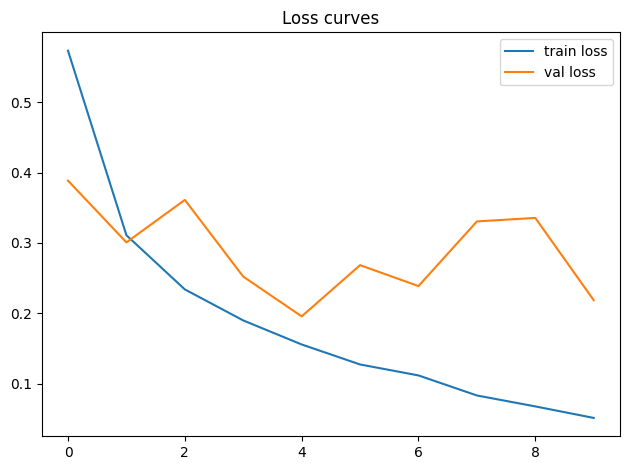

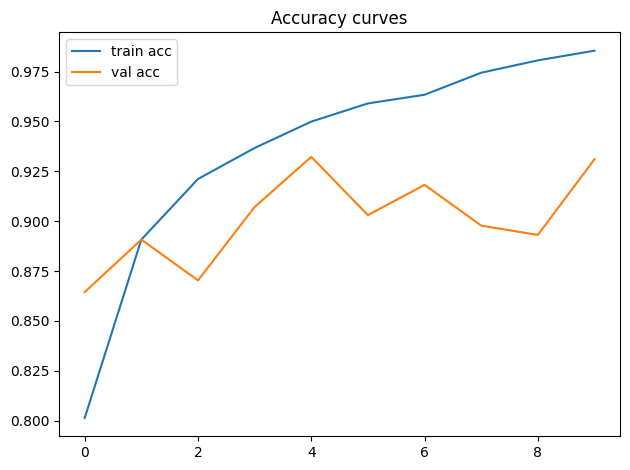

In [ ]:
plt.figure()
plt.plot(hist2["train_loss"], label="train loss")
plt.plot(hist2["val_loss"], label="val loss")
plt.legend()
plt.title("Loss curves")
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(hist2["train_acc"], label="train acc")
plt.plot(hist2["val_acc"], label="val acc")
plt.legend()
plt.title("Accuracy curves")
plt.tight_layout()
plt.show()

# **Model 3 - Baseline + Layer Normalization**

In [ ]:
class CNN_Model3_LN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2)
        self.ln1   = nn.LayerNorm([32, 14, 14])

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2)
        self.ln2   = nn.LayerNorm([64, 7, 7])

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2)
        self.ln3   = nn.LayerNorm([128, 3, 3])

        self.flatten_dim = 128 * 3 * 3
        self.fc = nn.Linear(self.flatten_dim, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.ln1(x)

        x = self.pool2(F.relu(self.conv2(x)))
        x = self.ln2(x)

        x = self.pool3(F.relu(self.conv3(x)))
        x = self.ln3(x)

        x = x.reshape(x.size(0), -1)
        x = self.fc(x)
        return x


In [ ]:
model3 = CNN_Model3_LN(num_channels, num_classes).to(device)
optimizer = torch.optim.Adam(model3.parameters(), lr=5e-4)
hist3 = train_model(model3, train_loader, val_loader, epochs=30, device=device, optimizer=optimizer, patience=5)

Epoch 01/30 | Train acc: 0.6801 - Train loss: 0.8834 | Val acc: 0.8131 - Val loss: 0.4954
Epoch 02/30 | Train acc: 0.8439 - Train loss: 0.4282 | Val acc: 0.8621 - Val loss: 0.3842
Epoch 03/30 | Train acc: 0.8813 - Train loss: 0.3277 | Val acc: 0.9013 - Val loss: 0.2935
Epoch 04/30 | Train acc: 0.9024 - Train loss: 0.2672 | Val acc: 0.8984 - Val loss: 0.2728
Epoch 05/30 | Train acc: 0.9270 - Train loss: 0.2133 | Val acc: 0.9095 - Val loss: 0.2518
Epoch 06/30 | Train acc: 0.9381 - Train loss: 0.1748 | Val acc: 0.9211 - Val loss: 0.2263
Epoch 07/30 | Train acc: 0.9538 - Train loss: 0.1413 | Val acc: 0.9346 - Val loss: 0.1923
Epoch 08/30 | Train acc: 0.9564 - Train loss: 0.1238 | Val acc: 0.9334 - Val loss: 0.1982
Epoch 09/30 | Train acc: 0.9659 - Train loss: 0.1012 | Val acc: 0.9322 - Val loss: 0.1889
Epoch 10/30 | Train acc: 0.9770 - Train loss: 0.0748 | Val acc: 0.9246 - Val loss: 0.2150
Epoch 11/30 | Train acc: 0.9808 - Train loss: 0.0673 | Val acc: 0.9305 - Val loss: 0.2044
Epoch 12/3

**Παρομοια αποτελεσματα με Batch Norm**

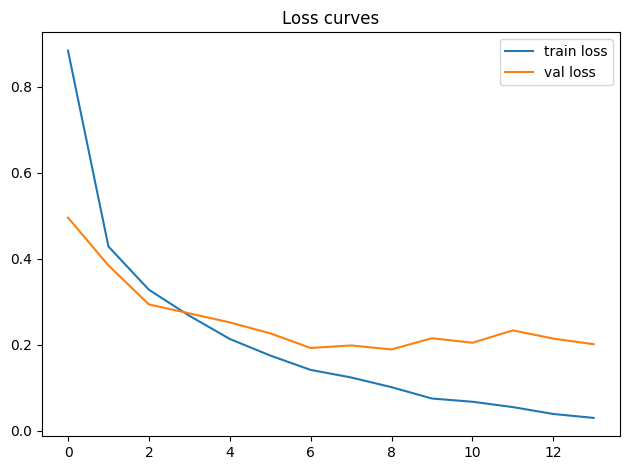

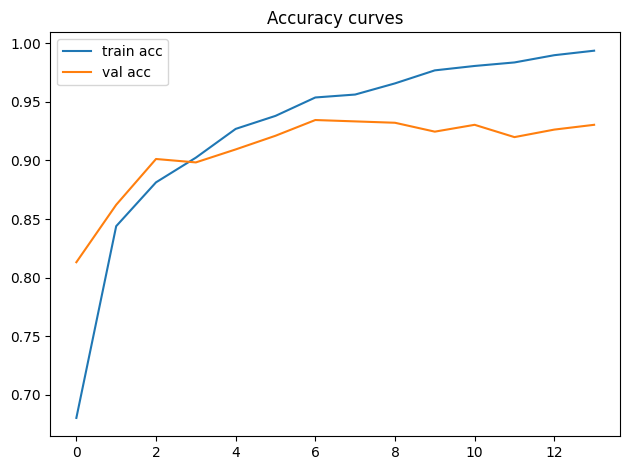

In [ ]:
plt.figure()
plt.plot(hist3["train_loss"], label="train loss")
plt.plot(hist3["val_loss"], label="val loss")
plt.legend()
plt.title("Loss curves")
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(hist3["train_acc"], label="train acc")
plt.plot(hist3["val_acc"], label="val acc")
plt.legend()
plt.title("Accuracy curves")
plt.tight_layout()
plt.show()

# **Model 4 - Baseline + Dropout**

In [ ]:
class CNN_Model4_Dropout(nn.Module):
    def __init__(self, in_channels, num_classes, p_drop=0.5):
        super().__init__()

        # Block 1
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2)

        # Block 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2)

        # Block 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2)

        # 28x28 -> 14 -> 7 -> 3
        self.flatten_dim = 128 * 3 * 3

        # Dropout + classifier
        self.dropout = nn.Dropout(p=p_drop)
        self.fc = nn.Linear(self.flatten_dim, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))

        x = x.reshape(x.size(0), -1)
        x = self.dropout(x)   # dropout
        x = self.fc(x)
        return x


In [ ]:
drop_rates = [0.2, 0.5, 0.7]
hist_drop = {}

for p in drop_rates:
    print(f"\n=== Training Model4 with Dropout rate: p={p} ===")

    model4 = CNN_Model4_Dropout(num_channels, num_classes, p_drop=p).to(device)

    optimizer = torch.optim.Adam(model4.parameters(), lr=1e-3)

    hist_drop[p] = train_model(model=model4, train_loader=train_loader, val_loader=val_loader, epochs=30, device=device, optimizer=optimizer, patience=7)


=== Training Model4 with Dropout rate: p=0.2 ===
Epoch 01/30 | Train acc: 0.5274 - Train loss: 1.2641 | Val acc: 0.7056 - Val loss: 0.8317
Epoch 02/30 | Train acc: 0.7455 - Train loss: 0.7105 | Val acc: 0.8143 - Val loss: 0.5724
Epoch 03/30 | Train acc: 0.7910 - Train loss: 0.5661 | Val acc: 0.8376 - Val loss: 0.4696
Epoch 04/30 | Train acc: 0.8208 - Train loss: 0.4996 | Val acc: 0.8516 - Val loss: 0.4356
Epoch 05/30 | Train acc: 0.8405 - Train loss: 0.4497 | Val acc: 0.8598 - Val loss: 0.3928
Epoch 06/30 | Train acc: 0.8490 - Train loss: 0.4186 | Val acc: 0.8464 - Val loss: 0.4085
Epoch 07/30 | Train acc: 0.8566 - Train loss: 0.3952 | Val acc: 0.8750 - Val loss: 0.3389
Epoch 08/30 | Train acc: 0.8713 - Train loss: 0.3617 | Val acc: 0.8832 - Val loss: 0.3194
Epoch 09/30 | Train acc: 0.8760 - Train loss: 0.3446 | Val acc: 0.8849 - Val loss: 0.3226
Epoch 10/30 | Train acc: 0.8827 - Train loss: 0.3241 | Val acc: 0.8989 - Val loss: 0.2924
Epoch 11/30 | Train acc: 0.8875 - Train loss: 0.31

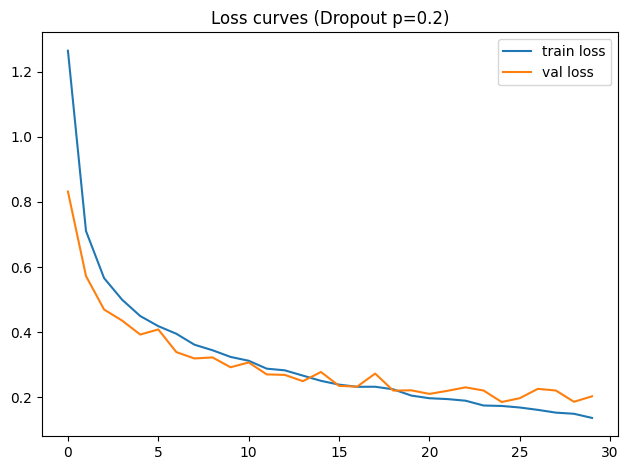

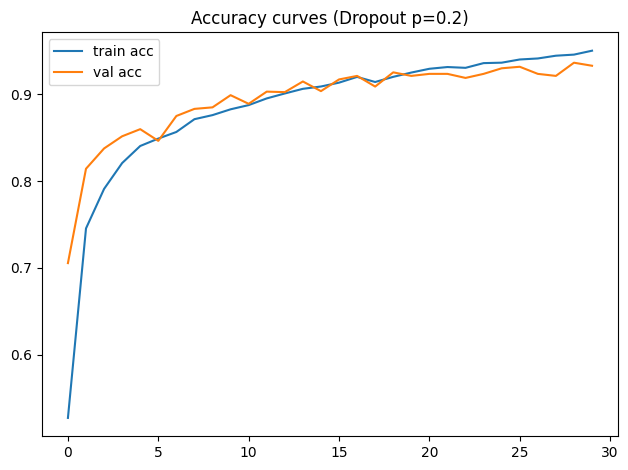

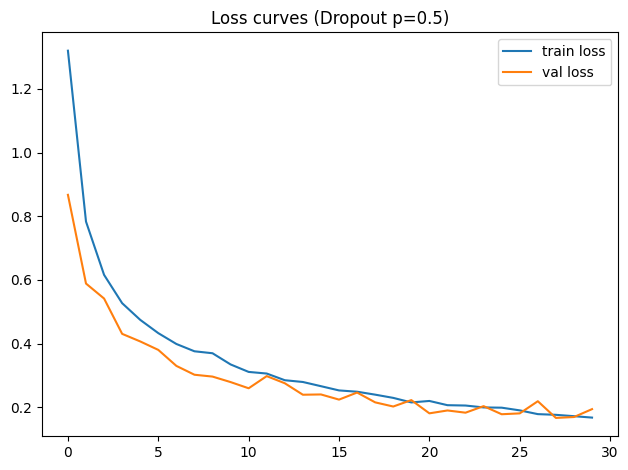

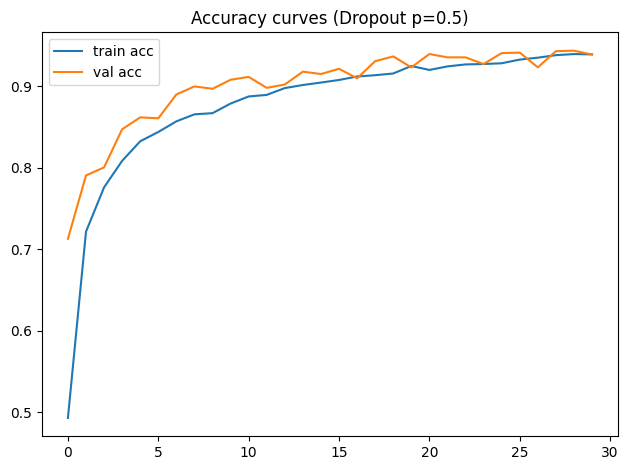

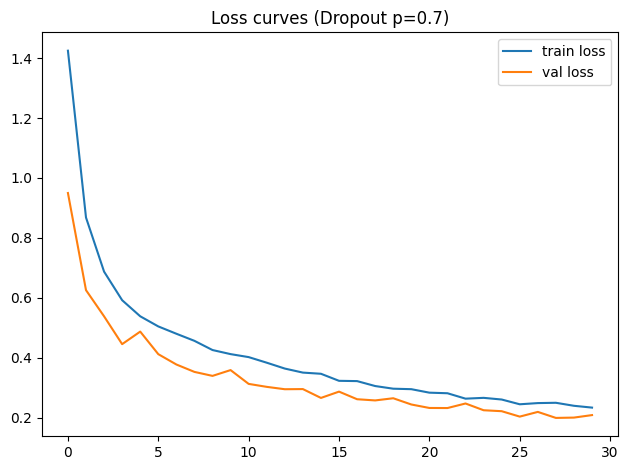

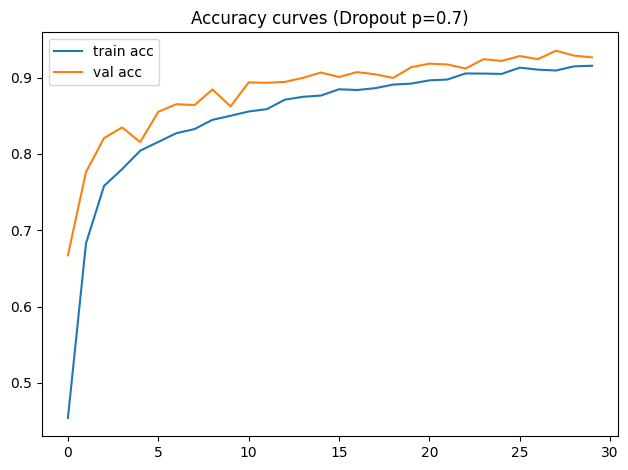

In [ ]:
for p in drop_rates:
    h = hist_drop[p]

    plt.figure()
    plt.plot(h["train_loss"], label="train loss")
    plt.plot(h["val_loss"], label="val loss")
    plt.title(f"Loss curves (Dropout p={p})")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure()
    plt.plot(h["train_acc"], label="train acc")
    plt.plot(h["val_acc"], label="val acc")
    plt.title(f"Accuracy curves (Dropout p={p})")
    plt.legend()
    plt.tight_layout()
    plt.show()


# **Model 5 - Baseline + Weight Decay**

In [ ]:
class CNN_Model5_Weight_Dec(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        # Block 1
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2)

        # Block 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2)

        # Block 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2)

        # 28x28 -> 14 -> 7 -> 3  (με MaxPool2d(2) τρεις φορές)
        self.flatten_dim = 128 * 3 * 3

        # Classifier (1 fully connected layer)
        self.fc = nn.Linear(self.flatten_dim, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))

        x = x.reshape(x.size(0), -1)   # flatten
        x = self.fc(x)                # logits
        return x


In [ ]:
model5 = CNN_Model5_Weight_Dec(num_channels, num_classes).to(device)

optimizer = torch.optim.Adam(model5.parameters(), lr=1e-3, weight_decay=1e-4)

hist5 = train_model(model=model5, train_loader=train_loader, val_loader=val_loader, epochs=30, device=device, optimizer=optimizer, patience=7)


Epoch 01/30 | Train acc: 0.5591 - Train loss: 1.1926 | Val acc: 0.7220 - Val loss: 0.7946
Epoch 02/30 | Train acc: 0.7741 - Train loss: 0.6494 | Val acc: 0.8172 - Val loss: 0.5226
Epoch 03/30 | Train acc: 0.8247 - Train loss: 0.4990 | Val acc: 0.8493 - Val loss: 0.4290
Epoch 04/30 | Train acc: 0.8395 - Train loss: 0.4522 | Val acc: 0.8657 - Val loss: 0.3829
Epoch 05/30 | Train acc: 0.8530 - Train loss: 0.4160 | Val acc: 0.8452 - Val loss: 0.4173
Epoch 06/30 | Train acc: 0.8670 - Train loss: 0.3753 | Val acc: 0.8750 - Val loss: 0.3545
Epoch 07/30 | Train acc: 0.8786 - Train loss: 0.3424 | Val acc: 0.8732 - Val loss: 0.3518
Epoch 08/30 | Train acc: 0.8844 - Train loss: 0.3263 | Val acc: 0.8849 - Val loss: 0.3272
Epoch 09/30 | Train acc: 0.8965 - Train loss: 0.2914 | Val acc: 0.8890 - Val loss: 0.3113
Epoch 10/30 | Train acc: 0.8981 - Train loss: 0.2861 | Val acc: 0.9071 - Val loss: 0.2784
Epoch 11/30 | Train acc: 0.9043 - Train loss: 0.2673 | Val acc: 0.9136 - Val loss: 0.2738
Epoch 12/3

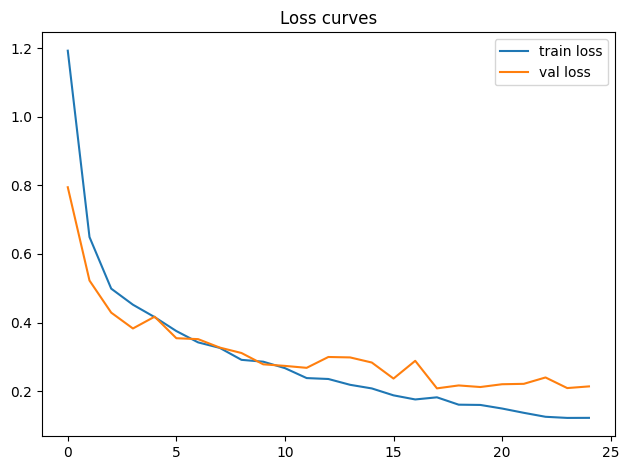

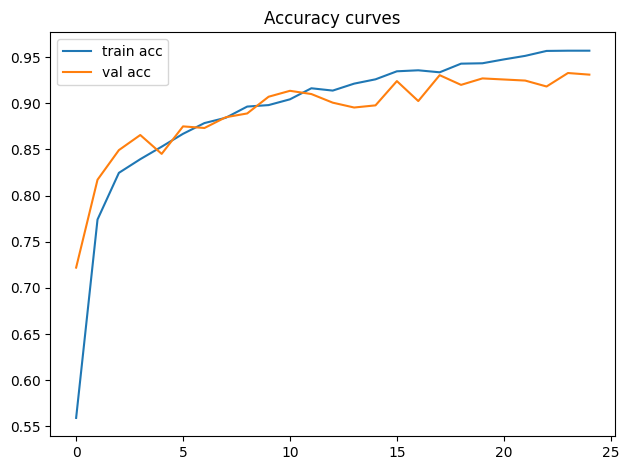

In [ ]:
plt.figure()
plt.plot(hist5["train_loss"], label="train loss")
plt.plot(hist5["val_loss"], label="val loss")
plt.legend()
plt.title("Loss curves")
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(hist5["train_acc"], label="train acc")
plt.plot(hist5["val_acc"], label="val acc")
plt.legend()
plt.title("Accuracy curves")
plt.tight_layout()
plt.show()

# **Model 6 - Baseline + Batch Norm + Dropout**

In [ ]:
class CNN_Model6_BN_Dropout(nn.Module):
    def __init__(self, in_channels, num_classes, p_drop=0.5):
        super().__init__()

        # Block 1
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2)

        # Block 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2)

        # Block 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2)

        # 28x28 → 14x14 → 7x7 → 3x3
        self.flatten_dim = 128 * 3 * 3

        # Dropout + classifier
        self.dropout = nn.Dropout(p=p_drop)
        self.fc = nn.Linear(self.flatten_dim, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))

        x = x.view(x.size(0), -1)

        x = self.dropout(x)
        x = self.fc(x)

        return x


In [ ]:
model6 = CNN_Model6_BN_Dropout(num_channels, num_classes, p_drop=0.5).to(device)

optimizer = torch.optim.Adam(model6.parameters(), lr=1e-4)

hist6 = train_model(model=model6, train_loader=train_loader, val_loader=val_loader, epochs=30, device=device, optimizer=optimizer, patience=5)


Epoch 01/30 | Train acc: 0.6204 - Train loss: 1.0847 | Val acc: 0.8248 - Val loss: 0.5701
Epoch 02/30 | Train acc: 0.7962 - Train loss: 0.5810 | Val acc: 0.8569 - Val loss: 0.4240
Epoch 03/30 | Train acc: 0.8408 - Train loss: 0.4571 | Val acc: 0.8925 - Val loss: 0.3564
Epoch 04/30 | Train acc: 0.8566 - Train loss: 0.4039 | Val acc: 0.9048 - Val loss: 0.3156
Epoch 05/30 | Train acc: 0.8757 - Train loss: 0.3492 | Val acc: 0.9077 - Val loss: 0.2989
Epoch 06/30 | Train acc: 0.8849 - Train loss: 0.3321 | Val acc: 0.9060 - Val loss: 0.2754
Epoch 07/30 | Train acc: 0.8951 - Train loss: 0.3009 | Val acc: 0.9141 - Val loss: 0.2533
Epoch 08/30 | Train acc: 0.9034 - Train loss: 0.2796 | Val acc: 0.9241 - Val loss: 0.2342
Epoch 09/30 | Train acc: 0.9090 - Train loss: 0.2646 | Val acc: 0.9241 - Val loss: 0.2293
Epoch 10/30 | Train acc: 0.9176 - Train loss: 0.2401 | Val acc: 0.9282 - Val loss: 0.2171
Epoch 11/30 | Train acc: 0.9198 - Train loss: 0.2381 | Val acc: 0.9305 - Val loss: 0.2098
Epoch 12/3

**Best Model so far**. Με την προσθηκη του dropout εχω ριξει την υπερκπαιδευση που ειχα στο μοντελο 2, και εχω πετυχει μια γενικευση μεγιστης ακριβειας 95%, με την εκπαιδευση να ειναι 96.5%, που δειχνει οτι δεν εχω overfitting.

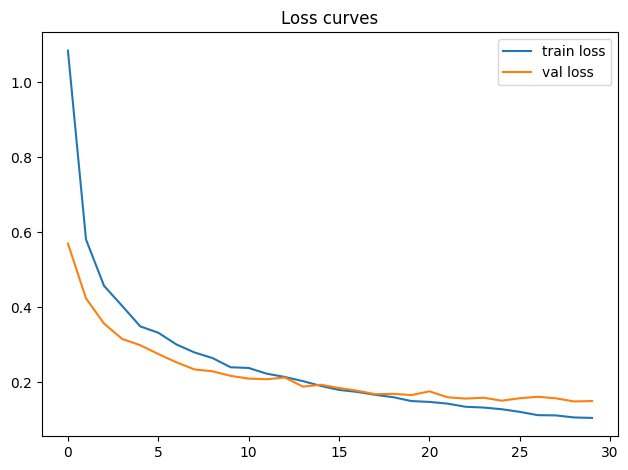

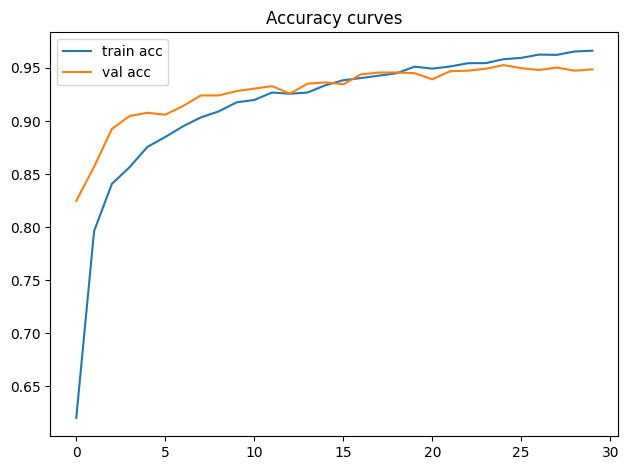

In [ ]:
plt.figure()
plt.plot(hist6["train_loss"], label="train loss")
plt.plot(hist6["val_loss"], label="val loss")
plt.legend()
plt.title("Loss curves")
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(hist6["train_acc"], label="train acc")
plt.plot(hist6["val_acc"], label="val acc")
plt.legend()
plt.title("Accuracy curves")
plt.tight_layout()
plt.show()

# **Model 7 - Baseline + Batch Norm + Dropout + Weight Decay**

In [ ]:
model7 = CNN_Model6_BN_Dropout(num_channels, num_classes, p_drop=0.5).to(device)

optimizer = torch.optim.Adam(model6.parameters(), lr=1e-3, weight_decay=1e-4)

hist7 = train_model(model=model7, train_loader=train_loader, val_loader=val_loader, epochs=30, device=device, optimizer=optimizer, patience=5)


Epoch 01/30 | Train acc: 0.1101 - Train loss: 2.4151 | Val acc: 0.0929 - Val loss: 2.2395
Epoch 02/30 | Train acc: 0.1069 - Train loss: 2.4080 | Val acc: 0.0929 - Val loss: 2.2394
Epoch 03/30 | Train acc: 0.1112 - Train loss: 2.4041 | Val acc: 0.0923 - Val loss: 2.2395
Epoch 04/30 | Train acc: 0.1095 - Train loss: 2.4110 | Val acc: 0.0923 - Val loss: 2.2391
Epoch 05/30 | Train acc: 0.1080 - Train loss: 2.4128 | Val acc: 0.0935 - Val loss: 2.2387
Epoch 06/30 | Train acc: 0.1094 - Train loss: 2.4183 | Val acc: 0.0929 - Val loss: 2.2401
Epoch 07/30 | Train acc: 0.1075 - Train loss: 2.4244 | Val acc: 0.0935 - Val loss: 2.2387
Epoch 08/30 | Train acc: 0.1093 - Train loss: 2.4149 | Val acc: 0.0923 - Val loss: 2.2383
Epoch 09/30 | Train acc: 0.1094 - Train loss: 2.4151 | Val acc: 0.0935 - Val loss: 2.2387
Epoch 10/30 | Train acc: 0.1133 - Train loss: 2.3985 | Val acc: 0.0929 - Val loss: 2.2397
Epoch 11/30 | Train acc: 0.1065 - Train loss: 2.4183 | Val acc: 0.0935 - Val loss: 2.2401
Epoch 12/3

**Too much Reguralization!**

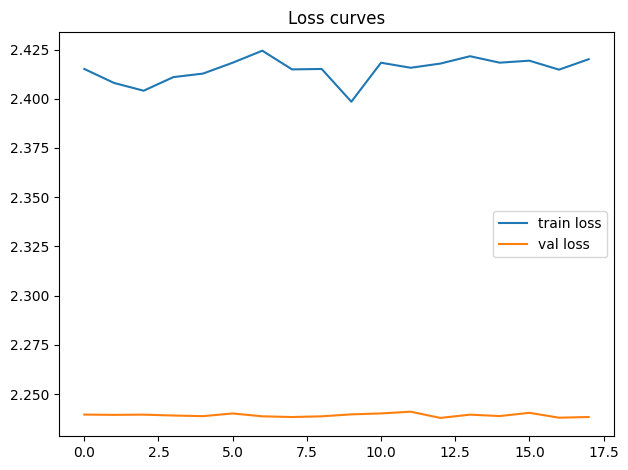

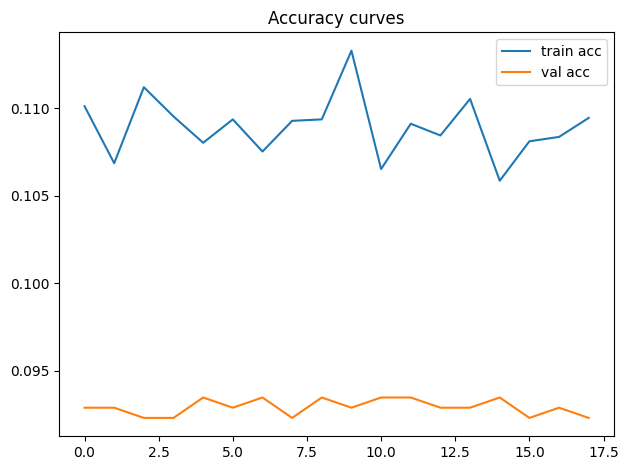

In [ ]:
plt.figure()
plt.plot(hist7["train_loss"], label="train loss")
plt.plot(hist7["val_loss"], label="val loss")
plt.legend()
plt.title("Loss curves")
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(hist7["train_acc"], label="train acc")
plt.plot(hist7["val_acc"], label="val acc")
plt.legend()
plt.title("Accuracy curves")
plt.tight_layout()
plt.show()

# **Model 8 - Train Best Model (Model 6) for 50 epochs**

In [ ]:
model8 = CNN_Model6_BN_Dropout(num_channels, num_classes, p_drop=0.5).to(device)
optimizer = torch.optim.Adam(model8.parameters(), lr=1e-4)
hist8 = train_model(model=model8, train_loader=train_loader, val_loader=val_loader, epochs=50, device=device, optimizer=optimizer, patience=10)

Epoch 01/50 | Train acc: 0.6102 - Train loss: 1.1008 | Val acc: 0.8218 - Val loss: 0.5812
Epoch 02/50 | Train acc: 0.7975 - Train loss: 0.5922 | Val acc: 0.8505 - Val loss: 0.4455
Epoch 03/50 | Train acc: 0.8327 - Train loss: 0.4784 | Val acc: 0.8692 - Val loss: 0.3795
Epoch 04/50 | Train acc: 0.8540 - Train loss: 0.4205 | Val acc: 0.8896 - Val loss: 0.3439
Epoch 05/50 | Train acc: 0.8699 - Train loss: 0.3725 | Val acc: 0.8966 - Val loss: 0.3138
Epoch 06/50 | Train acc: 0.8845 - Train loss: 0.3372 | Val acc: 0.8984 - Val loss: 0.2959
Epoch 07/50 | Train acc: 0.8889 - Train loss: 0.3132 | Val acc: 0.9077 - Val loss: 0.2777
Epoch 08/50 | Train acc: 0.8966 - Train loss: 0.2962 | Val acc: 0.9089 - Val loss: 0.2668
Epoch 09/50 | Train acc: 0.9038 - Train loss: 0.2752 | Val acc: 0.9147 - Val loss: 0.2603
Epoch 10/50 | Train acc: 0.9117 - Train loss: 0.2542 | Val acc: 0.9171 - Val loss: 0.2447
Epoch 11/50 | Train acc: 0.9165 - Train loss: 0.2403 | Val acc: 0.9194 - Val loss: 0.2444
Epoch 12/5

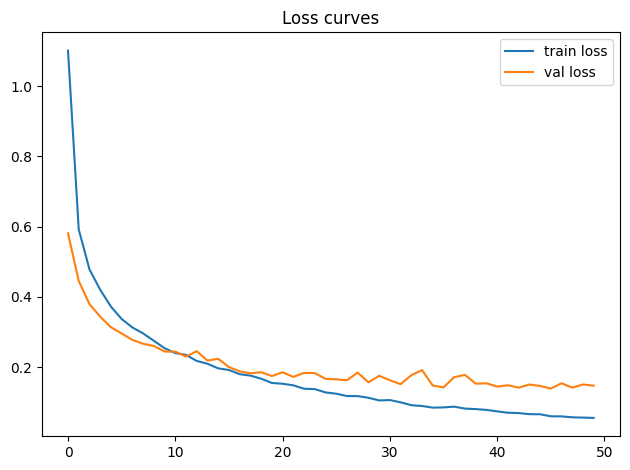

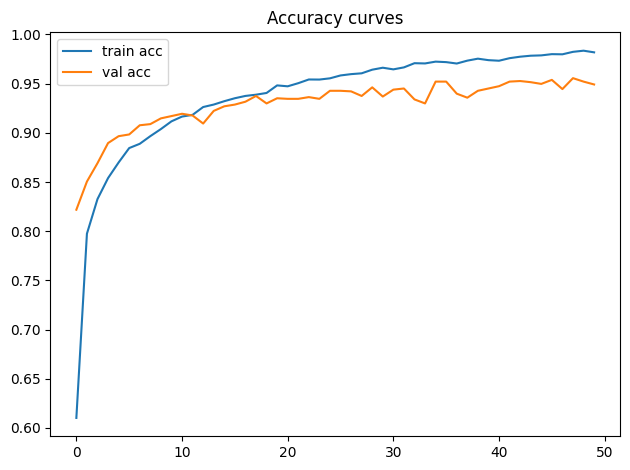

In [ ]:
plt.figure()
plt.plot(hist8["train_loss"], label="train loss")
plt.plot(hist8["val_loss"], label="val loss")
plt.legend()
plt.title("Loss curves")
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(hist8["train_acc"], label="train acc")
plt.plot(hist8["val_acc"], label="val acc")
plt.legend()
plt.title("Accuracy curves")
plt.tight_layout()
plt.show()

# **Model 9 - Model 6 + Data Augmentation**

In [ ]:
# Augmentation transforms
train_transform_aug = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5), transforms.RandomRotation(degrees=10),transforms.ToTensor() ])

eval_transform = transforms.Compose([transforms.ToTensor()])

# Augmented datasets/loaders
train_dataset_aug = DataClass(split="train", download=True, transform=train_transform_aug)
val_dataset_aug   = DataClass(split="val",   download=True, transform=eval_transform)
test_dataset_aug  = DataClass(split="test",  download=True, transform=eval_transform)

train_loader_aug = DataLoader(train_dataset_aug, batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=True)
val_loader_aug   = DataLoader(val_dataset_aug,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader_aug  = DataLoader(test_dataset_aug,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)


In [ ]:
model9 = CNN_Model6_BN_Dropout(num_channels, num_classes, p_drop=0.5).to(device)
optimizer = torch.optim.Adam(model9.parameters(), lr=1e-4)
hist9 = train_model(model=model9, train_loader=train_loader_aug, val_loader=val_loader_aug, epochs=50, device=device, optimizer=optimizer, patience=10)

Epoch 01/50 | Train acc: 0.5714 - Train loss: 1.2087 | Val acc: 0.7921 - Val loss: 0.6790
Epoch 02/50 | Train acc: 0.7645 - Train loss: 0.6739 | Val acc: 0.8265 - Val loss: 0.4961
Epoch 03/50 | Train acc: 0.8086 - Train loss: 0.5352 | Val acc: 0.8435 - Val loss: 0.4262
Epoch 04/50 | Train acc: 0.8355 - Train loss: 0.4700 | Val acc: 0.8668 - Val loss: 0.3846
Epoch 05/50 | Train acc: 0.8490 - Train loss: 0.4249 | Val acc: 0.8884 - Val loss: 0.3412
Epoch 06/50 | Train acc: 0.8617 - Train loss: 0.3891 | Val acc: 0.8902 - Val loss: 0.3153
Epoch 07/50 | Train acc: 0.8745 - Train loss: 0.3591 | Val acc: 0.8966 - Val loss: 0.2986
Epoch 08/50 | Train acc: 0.8762 - Train loss: 0.3432 | Val acc: 0.9019 - Val loss: 0.2858
Epoch 09/50 | Train acc: 0.8844 - Train loss: 0.3261 | Val acc: 0.9106 - Val loss: 0.2806
Epoch 10/50 | Train acc: 0.8870 - Train loss: 0.3159 | Val acc: 0.9153 - Val loss: 0.2587
Epoch 11/50 | Train acc: 0.8945 - Train loss: 0.2996 | Val acc: 0.9136 - Val loss: 0.2477
Epoch 12/5

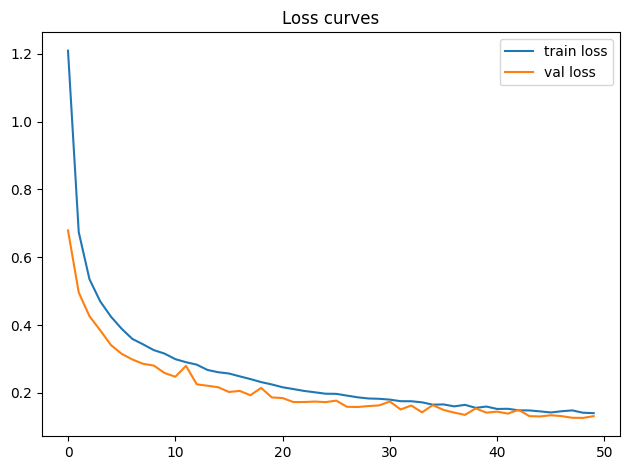

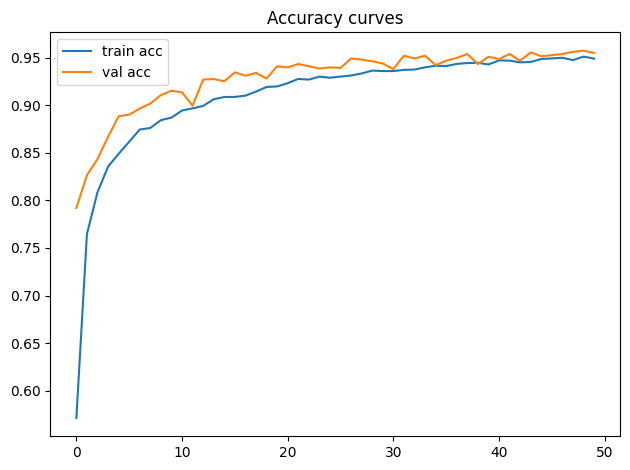

In [ ]:
plt.figure()
plt.plot(hist9["train_loss"], label="train loss")
plt.plot(hist9["val_loss"], label="val loss")
plt.legend()
plt.title("Loss curves")
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(hist9["train_acc"], label="train acc")
plt.plot(hist9["val_acc"], label="val acc")
plt.legend()
plt.title("Accuracy curves")
plt.tight_layout()
plt.show()

In [7]:
def evaluate_accuracy(model, loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).long().view(-1)

            logits = model(x)
            preds = torch.argmax(logits, dim=1)

            correct += (preds == y).sum().item()
            total += y.size(0)

    return correct / total


In [ ]:
test_acc = evaluate_accuracy(model9, test_loader, device)
print("Test accuracy:", test_acc)

Test accuracy: 0.9541069862613271


In [6]:
@torch.no_grad()
def confusion_matrix_plot(model, dataloader, class_names, device, figsize=(12, 10)):
    model.eval()
    num_classes = len(class_names)

    # 1) Υπολογισμός confusion matrix (counts)
    cm = torch.zeros(num_classes, num_classes, dtype=torch.int64)

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device).view(-1)

        outputs = model(images)
        preds = outputs.argmax(dim=1)

        for t, p in zip(labels, preds):
            cm[t.long(), p.long()] += 1

    cm_np = cm.cpu().numpy()

    # 2) Plot
    plt.figure(figsize=figsize)
    plt.imshow(cm_np, interpolation="nearest", cmap="Blues")
    plt.colorbar()
    plt.title("Confusion Matrix")

    plt.xlabel("Predicted label")
    plt.ylabel("True label")

    ticks = range(num_classes)
    plt.xticks(ticks, class_names, rotation=45, ha="right")
    plt.yticks(ticks, class_names)

    # 3) Numbers inside cells
    max_val = cm_np.max()
    for i in range(num_classes):
        for j in range(num_classes):
            color = "white" if cm_np[i, j] > max_val / 2 else "black"
            plt.text(j, i, cm_np[i, j], ha="center", va="center", color=color)

    plt.tight_layout()
    plt.show()

    return cm


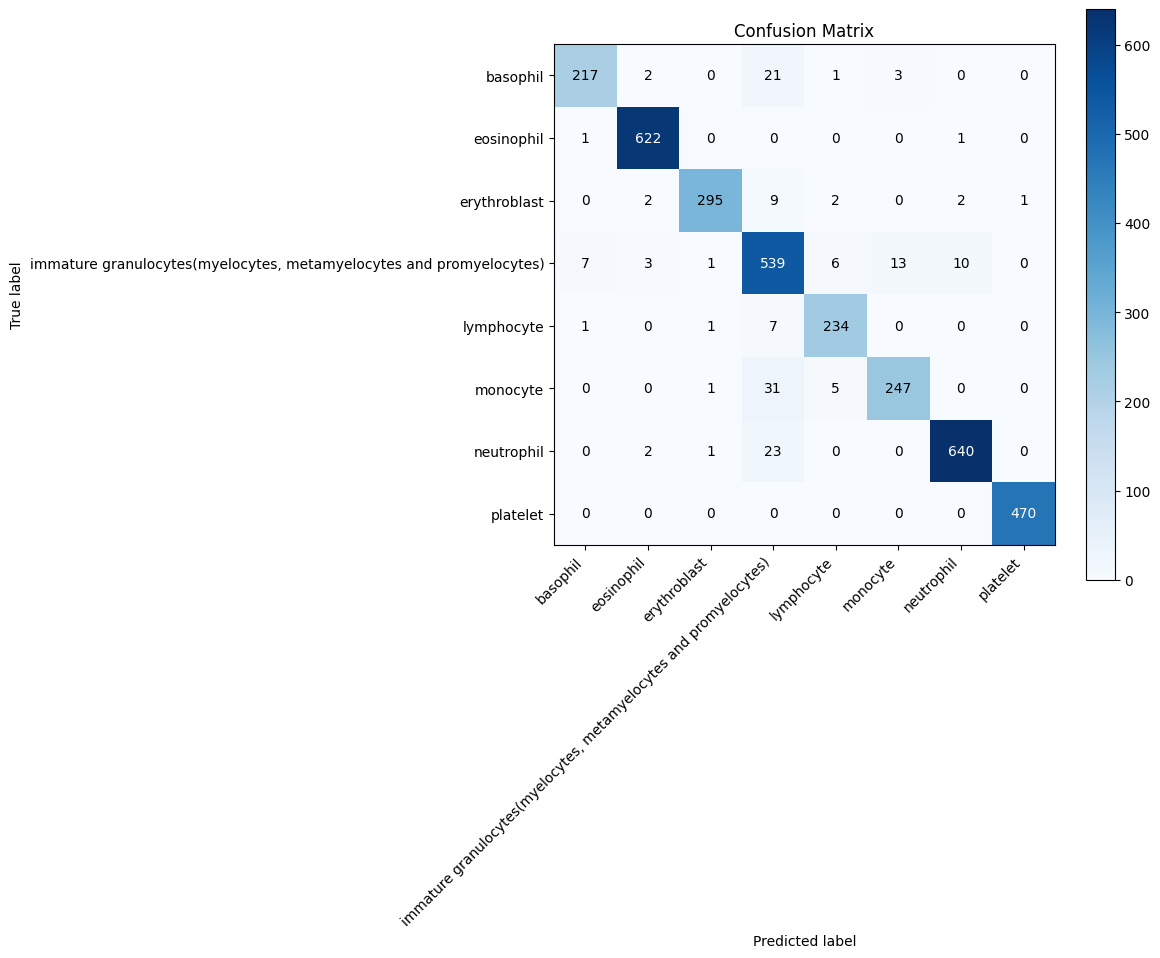

In [ ]:
cm = confusion_matrix_plot(model9, test_loader, class_names=class_names, device=device)

# **Part 2 - Transfer Learning on ResNet 18**

In [8]:
from torchvision import models

# Builds a resnet model every time it is called
def build_resnet18(num_classes, device):
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)

In [9]:
model = build_resnet18(num_classes, device)

# Freeze everything
for param in model.parameters():
    param.requires_grad = False
#  Unfreeze only the classifier
for param in model.fc.parameters():
    param.requires_grad = True

model = model.to(device)
print(model.fc)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 185MB/s]


Linear(in_features=512, out_features=8, bias=True)


In [10]:
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)
hist10 = train_model(model=model, train_loader=train_loader, val_loader=val_loader, epochs=20, device=device, optimizer=optimizer, patience=10)

Epoch 01/20 | Train acc: 0.5934 - Train loss: 1.1684 | Val acc: 0.6887 - Val loss: 0.9026
Epoch 02/20 | Train acc: 0.6883 - Train loss: 0.8771 | Val acc: 0.7190 - Val loss: 0.7872
Epoch 03/20 | Train acc: 0.7081 - Train loss: 0.8261 | Val acc: 0.7220 - Val loss: 0.7834
Epoch 04/20 | Train acc: 0.7221 - Train loss: 0.7799 | Val acc: 0.7459 - Val loss: 0.7565
Epoch 05/20 | Train acc: 0.7261 - Train loss: 0.7730 | Val acc: 0.7436 - Val loss: 0.7325
Epoch 06/20 | Train acc: 0.7296 - Train loss: 0.7615 | Val acc: 0.7459 - Val loss: 0.7461
Epoch 07/20 | Train acc: 0.7357 - Train loss: 0.7473 | Val acc: 0.7424 - Val loss: 0.7333
Epoch 08/20 | Train acc: 0.7342 - Train loss: 0.7461 | Val acc: 0.7518 - Val loss: 0.7398
Epoch 09/20 | Train acc: 0.7358 - Train loss: 0.7478 | Val acc: 0.7471 - Val loss: 0.7207
Epoch 10/20 | Train acc: 0.7399 - Train loss: 0.7238 | Val acc: 0.7371 - Val loss: 0.7468
Epoch 11/20 | Train acc: 0.7367 - Train loss: 0.7319 | Val acc: 0.7383 - Val loss: 0.7292
Epoch 12/2

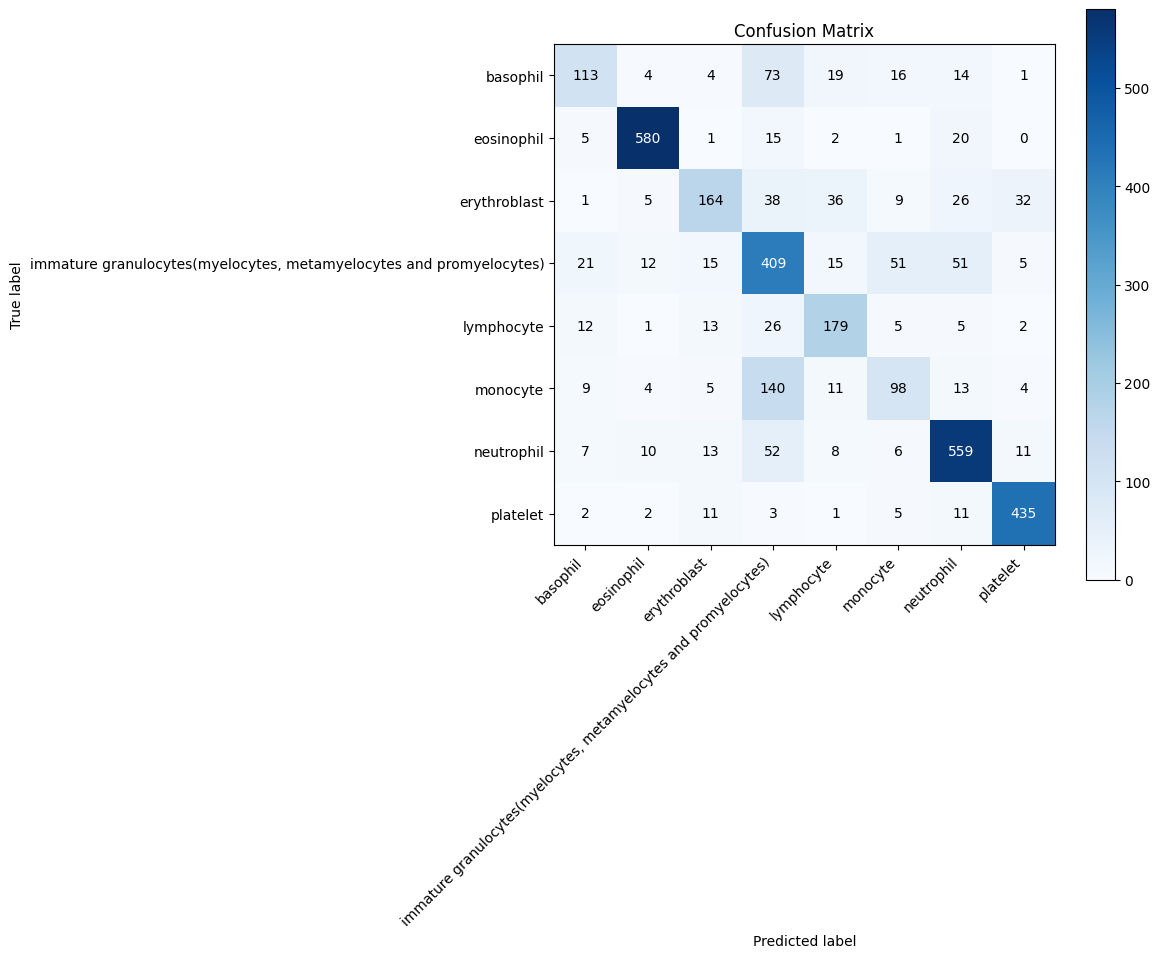

In [11]:
cm = confusion_matrix_plot(model, test_loader, class_names=class_names, device=device)

# **Fine Tuning on Classifier Head + Layer 4**

In [12]:
model = build_resnet18(num_classes, device)
train_loader_32 = DataLoader(train_dataset, batch_size=32, shuffle=True,  num_workers=2, pin_memory=True)
val_loader_32 = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

# Freeze everything
for param in model.parameters():
    param.requires_grad = False
#  Unfreeze only the classifier
for param in model.fc.parameters():
    param.requires_grad = True
# Unfreeze Layer 4
for p in model.layer4.parameters():
    p.requires_grad = True

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)    # give only the parameters that return true on p.requrires_grad to the optimizer
hist11 = train_model(model=model, train_loader=train_loader_32, val_loader=val_loader_32, epochs=15, device=device, optimizer=optimizer, patience=10)

Epoch 01/15 | Train acc: 0.7230 - Train loss: 0.7719 | Val acc: 0.8359 - Val loss: 0.4797
Epoch 02/15 | Train acc: 0.8288 - Train loss: 0.4783 | Val acc: 0.8534 - Val loss: 0.4224
Epoch 03/15 | Train acc: 0.8703 - Train loss: 0.3692 | Val acc: 0.8680 - Val loss: 0.3961
Epoch 04/15 | Train acc: 0.8892 - Train loss: 0.3122 | Val acc: 0.8662 - Val loss: 0.3973
Epoch 05/15 | Train acc: 0.9099 - Train loss: 0.2558 | Val acc: 0.8645 - Val loss: 0.3769
Epoch 06/15 | Train acc: 0.9225 - Train loss: 0.2217 | Val acc: 0.8627 - Val loss: 0.4021
Epoch 07/15 | Train acc: 0.9349 - Train loss: 0.1854 | Val acc: 0.8651 - Val loss: 0.4058
Epoch 08/15 | Train acc: 0.9451 - Train loss: 0.1505 | Val acc: 0.8686 - Val loss: 0.4280
Epoch 09/15 | Train acc: 0.9474 - Train loss: 0.1457 | Val acc: 0.8768 - Val loss: 0.4162
Epoch 10/15 | Train acc: 0.9580 - Train loss: 0.1218 | Val acc: 0.8721 - Val loss: 0.4141
Epoch 11/15 | Train acc: 0.9625 - Train loss: 0.1080 | Val acc: 0.8697 - Val loss: 0.4451
Epoch 12/1

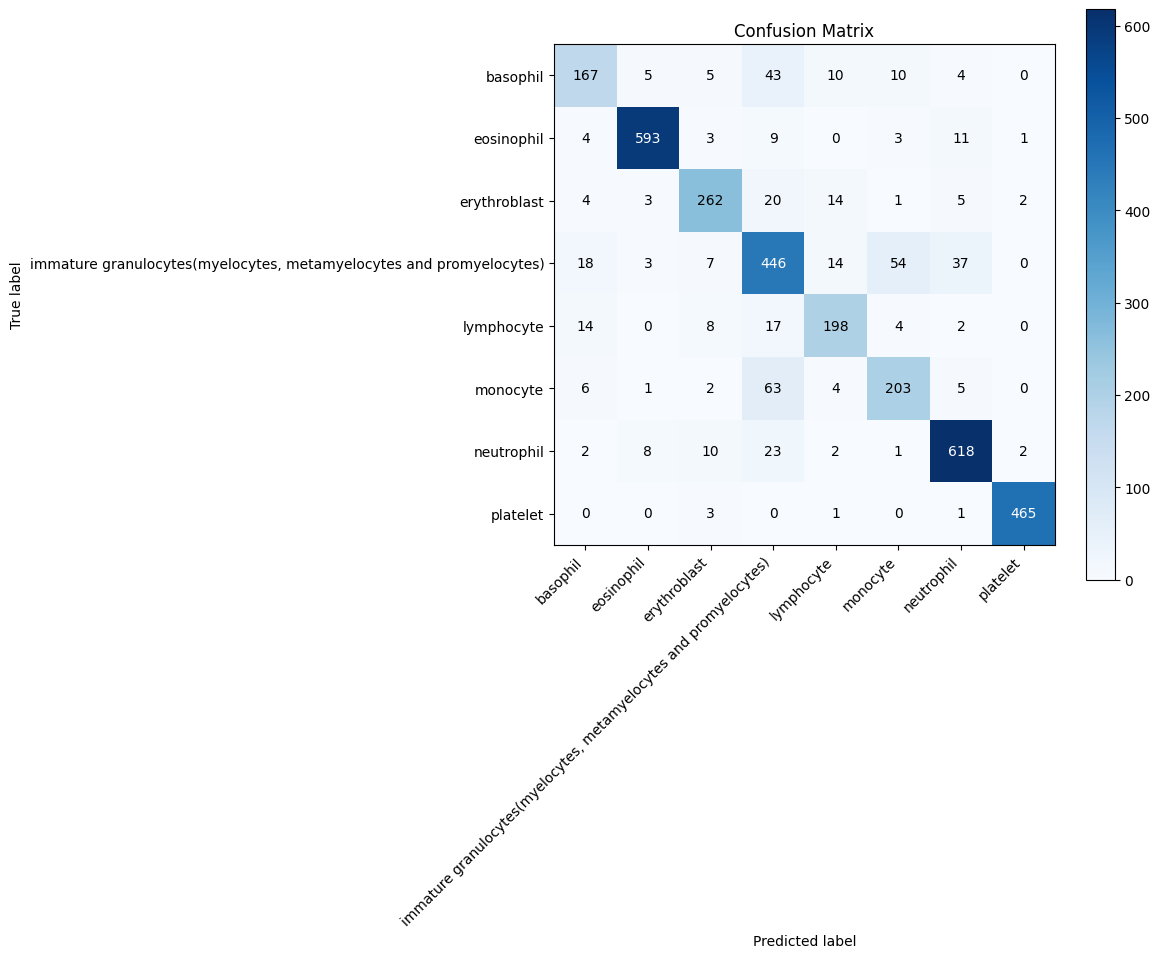

In [13]:
cm = confusion_matrix_plot(model, test_loader, class_names=class_names, device=device)

# **Fine Tuning on Classifier Head + Layer 4 + Layer 3**

In [14]:
model = build_resnet18(num_classes, device)

# freeze all
for p in model.parameters():
    p.requires_grad = False

# unfreeze head + last 2 blocks
for p in model.fc.parameters():
    p.requires_grad = True
for p in model.layer4.parameters():
    p.requires_grad = True
for p in model.layer3.parameters():
    p.requires_grad = True

In [15]:
optimizer = torch.optim.Adam([{"params": model.fc.parameters(), "lr": 1e-3}, {"params": model.layer4.parameters(), "lr": 1e-4}, {"params": model.layer3.parameters(), "lr": 1e-4},])
hist12 = train_model(model=model, train_loader=train_loader_32, val_loader=val_loader_32, epochs=15, device=device, optimizer=optimizer, patience=10)

Epoch 01/15 | Train acc: 0.7717 - Train loss: 0.6461 | Val acc: 0.8703 - Val loss: 0.3478
Epoch 02/15 | Train acc: 0.8804 - Train loss: 0.3513 | Val acc: 0.8914 - Val loss: 0.3060
Epoch 03/15 | Train acc: 0.9100 - Train loss: 0.2554 | Val acc: 0.9001 - Val loss: 0.2763
Epoch 04/15 | Train acc: 0.9286 - Train loss: 0.1985 | Val acc: 0.8966 - Val loss: 0.2953
Epoch 05/15 | Train acc: 0.9433 - Train loss: 0.1690 | Val acc: 0.9100 - Val loss: 0.2622
Epoch 06/15 | Train acc: 0.9444 - Train loss: 0.1566 | Val acc: 0.9124 - Val loss: 0.2553
Epoch 07/15 | Train acc: 0.9538 - Train loss: 0.1333 | Val acc: 0.9176 - Val loss: 0.2595
Epoch 08/15 | Train acc: 0.9628 - Train loss: 0.1066 | Val acc: 0.9188 - Val loss: 0.2600
Epoch 09/15 | Train acc: 0.9661 - Train loss: 0.1056 | Val acc: 0.9147 - Val loss: 0.2717
Epoch 10/15 | Train acc: 0.9703 - Train loss: 0.0939 | Val acc: 0.9171 - Val loss: 0.2918
Epoch 11/15 | Train acc: 0.9742 - Train loss: 0.0781 | Val acc: 0.9054 - Val loss: 0.3398
Epoch 12/1

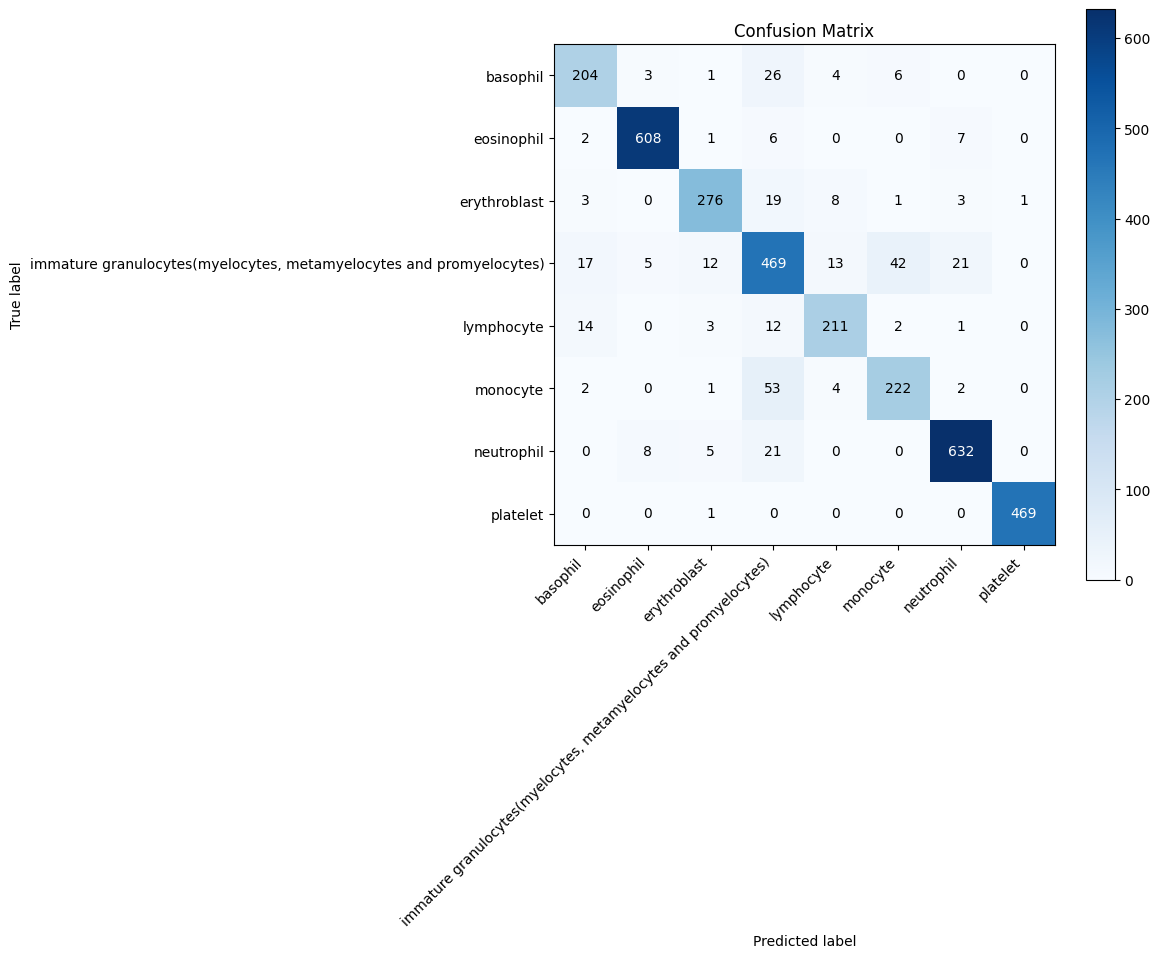

In [16]:
cm = confusion_matrix_plot(model, test_loader, class_names=class_names, device=device)

# **Fine Tuning on Classifier Head + Layer 2 + Layer 3 + Layer 4**

In [17]:
model = build_resnet18(num_classes, device)

# freeze all
for p in model.parameters():
    p.requires_grad = False

# unfreeze head + last 3 blocks
for p in model.fc.parameters():
    p.requires_grad = True
for p in model.layer4.parameters():
    p.requires_grad = True
for p in model.layer3.parameters():
    p.requires_grad = True
for p in model.layer2.parameters():
    p.requires_grad = True

In [19]:
optimizer = torch.optim.Adam([{"params": model.fc.parameters(), "lr": 1e-3}, {"params": model.layer4.parameters(), "lr": 1e-4},
 {"params": model.layer3.parameters(), "lr": 1e-4}, {"params": model.layer2.parameters(), "lr": 5e-5}])
hist13 = train_model(model=model, train_loader=train_loader_32, val_loader=val_loader_32, epochs=15, device=device, optimizer=optimizer, patience=10)

Epoch 01/15 | Train acc: 0.7811 - Train loss: 0.6167 | Val acc: 0.8814 - Val loss: 0.3238
Epoch 02/15 | Train acc: 0.8890 - Train loss: 0.3202 | Val acc: 0.9206 - Val loss: 0.2288
Epoch 03/15 | Train acc: 0.9236 - Train loss: 0.2193 | Val acc: 0.9241 - Val loss: 0.2294
Epoch 04/15 | Train acc: 0.9354 - Train loss: 0.1831 | Val acc: 0.9317 - Val loss: 0.2100
Epoch 05/15 | Train acc: 0.9506 - Train loss: 0.1506 | Val acc: 0.9042 - Val loss: 0.2987
Epoch 06/15 | Train acc: 0.9572 - Train loss: 0.1296 | Val acc: 0.9241 - Val loss: 0.2350
Epoch 07/15 | Train acc: 0.9653 - Train loss: 0.1035 | Val acc: 0.9387 - Val loss: 0.2083
Epoch 08/15 | Train acc: 0.9655 - Train loss: 0.1028 | Val acc: 0.9200 - Val loss: 0.2714
Epoch 09/15 | Train acc: 0.9650 - Train loss: 0.1025 | Val acc: 0.9352 - Val loss: 0.2196
Epoch 10/15 | Train acc: 0.9777 - Train loss: 0.0650 | Val acc: 0.9293 - Val loss: 0.2373
Epoch 11/15 | Train acc: 0.9786 - Train loss: 0.0731 | Val acc: 0.9270 - Val loss: 0.2498
Epoch 12/1

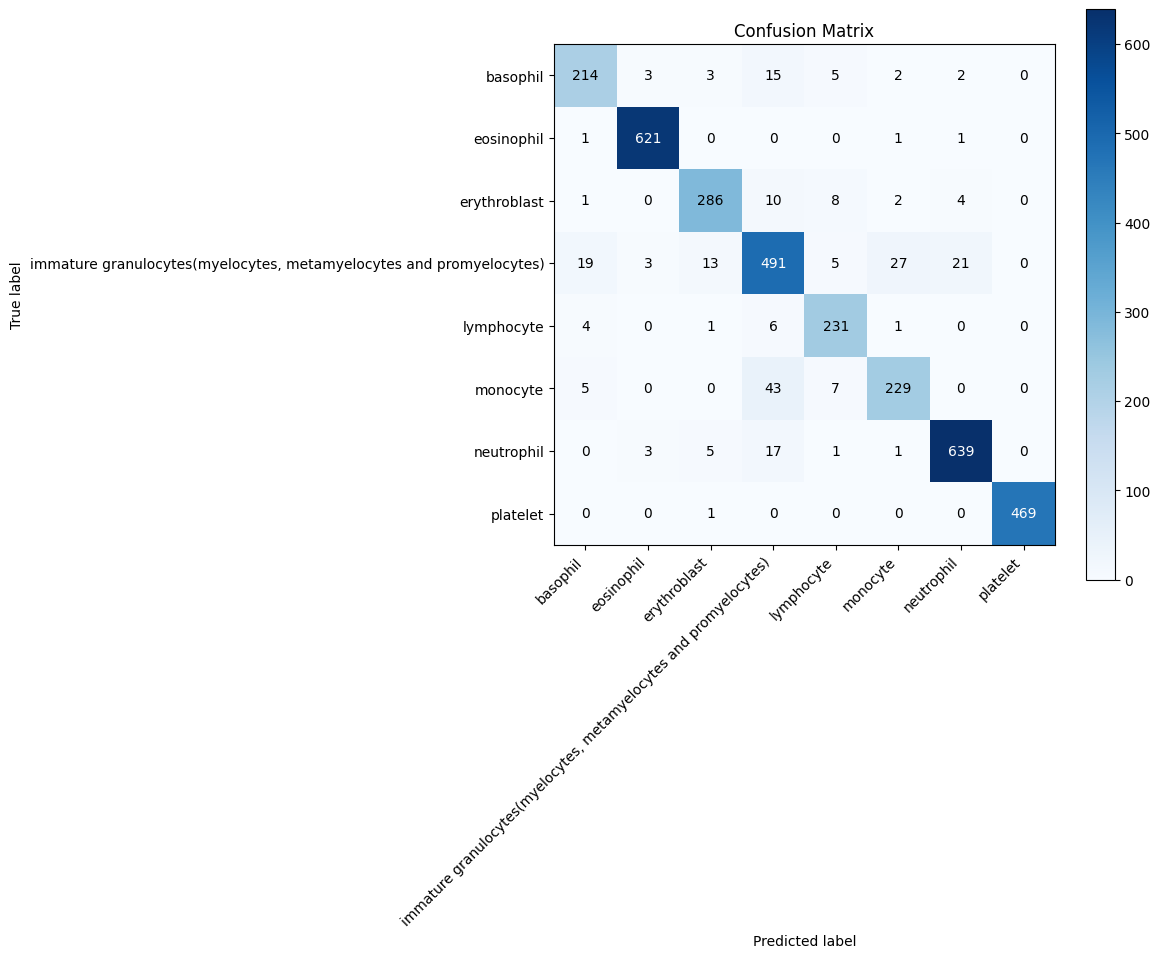

In [20]:
cm = confusion_matrix_plot(model, test_loader, class_names=class_names, device=device)

# **Learning Curves - Loss**

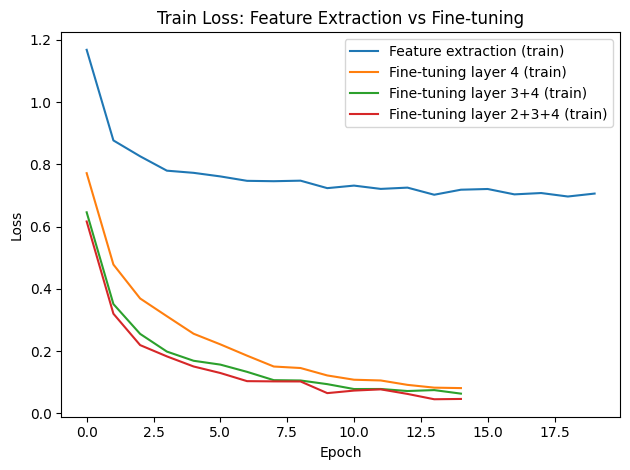

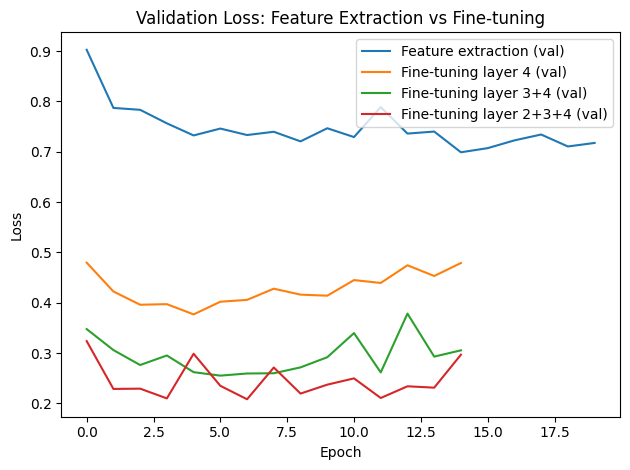

In [21]:
# Train Loss
plt.figure()
plt.plot(hist10["train_loss"], label="Feature extraction (train)")
plt.plot(hist11["train_loss"], label="Fine-tuning layer 4 (train)")
plt.plot(hist12["train_loss"], label="Fine-tuning layer 3+4 (train)")
plt.plot(hist13["train_loss"], label="Fine-tuning layer 2+3+4 (train)")
plt.title("Train Loss: Feature Extraction vs Fine-tuning")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# Val Loss
plt.figure()
plt.plot(hist10["val_loss"], label="Feature extraction (val)")
plt.plot(hist11["val_loss"], label="Fine-tuning layer 4 (val)")
plt.plot(hist12["val_loss"], label="Fine-tuning layer 3+4 (val)")
plt.plot(hist13["val_loss"], label="Fine-tuning layer 2+3+4 (val)")
plt.title("Validation Loss: Feature Extraction vs Fine-tuning")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()


# **Learning Curves - Accuracy**

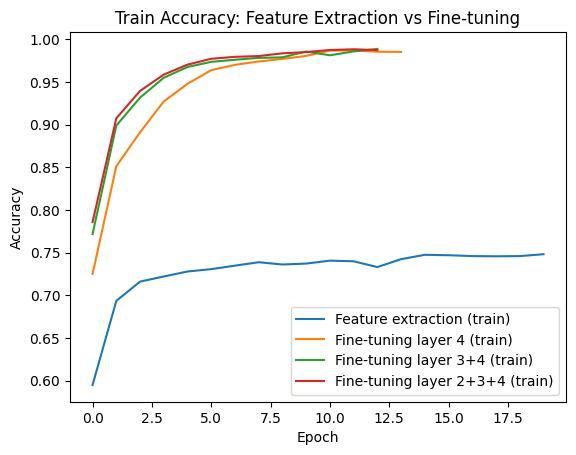

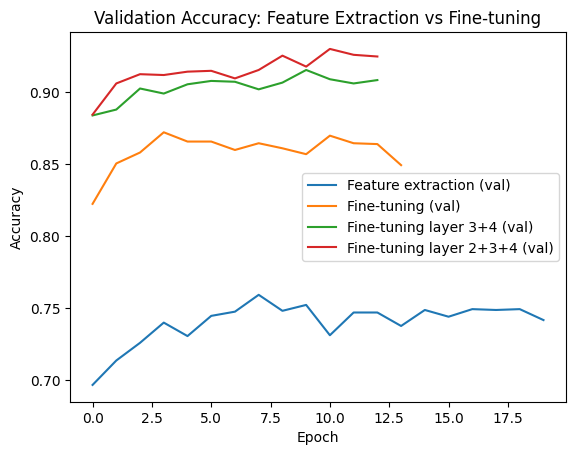

In [ ]:
# Train Accuracy
plt.figure()
plt.plot(hist10["train_acc"], label="Feature extraction (train)")
plt.plot(hist11["train_acc"], label="Fine-tuning layer 4 (train)")
plt.plot(hist12["train_acc"], label="Fine-tuning layer 3+4 (train)")
plt.plot(hist13["train_acc"], label="Fine-tuning layer 2+3+4 (train)")
plt.title("Train Accuracy: Feature Extraction vs Fine-tuning")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Val Accuracy
plt.figure()
plt.plot(hist10["val_acc"], label="Feature extraction (val)")
plt.plot(hist11["val_acc"], label="Fine-tuning (val)")
plt.plot(hist12["val_acc"], label="Fine-tuning layer 3+4 (val)")
plt.plot(hist13["val_acc"], label="Fine-tuning layer 2+3+4 (val)")
plt.title("Validation Accuracy: Feature Extraction vs Fine-tuning")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


# **Test Accuracy of Last Model**

In [22]:
test_acc = evaluate_accuracy(model, test_loader, device)
print("Test accuracy:", test_acc)

Test accuracy: 0.92955276235019


# **Part 3 - Transfer Learning on Transformer (DeIT)**

In [23]:
import timm
import torch.nn as nn
from timm.data import resolve_data_config, create_transform

# Builds a transformer model every time it's called
def build_deit(num_classes, device, model_name="deit_tiny_patch16_224", pretrained=True):
    model = timm.create_model(model_name, pretrained=pretrained)    # loads DeiT model
    model.reset_classifier(num_classes)             # replace classifier with 7 neurons
    return model.to(device)

# build model
model = build_deit(num_classes, device)

# freeze all layers
for p in model.parameters():
    p.requires_grad = False

# unfreeze head
for p in model.head.parameters():
    p.requires_grad = True

# transforms for DeiT transformer
data_cfg = resolve_data_config({}, model=model)     # returns dictionary with transformer details
train_tf = create_transform(**data_cfg, is_training=True)     # contains transforms according to dictionary, that will be applied to data
eval_tf  = create_transform(**data_cfg, is_training=False)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

In [24]:
# Rebuild datasets with new transforms
train_dataset_deit = DataClass(split="train", download=True, transform=train_tf)
val_dataset_deit   = DataClass(split="val",   download=True, transform=eval_tf)
test_dataset_deit  = DataClass(split="test",  download=True, transform=eval_tf)

# Loaders for DeiT
train_loader_deit = DataLoader(train_dataset_deit, batch_size=32, shuffle=True,  num_workers=2, pin_memory=True)
val_loader_deit   = DataLoader(val_dataset_deit,   batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_loader_deit  = DataLoader(test_dataset_deit,  batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

# Sample check
xb, yb = next(iter(train_loader_deit))
print("DeiT batch:", xb.shape)

DeiT batch: torch.Size([32, 3, 224, 224])


In [25]:
optimizer = optim.Adam(model.head.parameters(), lr=1e-3)
hist14 = train_model(model=model, train_loader=train_loader_deit, val_loader=val_loader_deit, epochs=15, device=device, optimizer=optimizer, patience=10)

Epoch 01/15 | Train acc: 0.5373 - Train loss: 1.3267 | Val acc: 0.6641 - Val loss: 0.9385
Epoch 02/15 | Train acc: 0.6409 - Train loss: 1.0343 | Val acc: 0.7185 - Val loss: 0.8231
Epoch 03/15 | Train acc: 0.6658 - Train loss: 0.9609 | Val acc: 0.7348 - Val loss: 0.7605
Epoch 04/15 | Train acc: 0.6796 - Train loss: 0.9138 | Val acc: 0.7126 - Val loss: 0.7773
Epoch 05/15 | Train acc: 0.6870 - Train loss: 0.8954 | Val acc: 0.7634 - Val loss: 0.6938
Epoch 06/15 | Train acc: 0.6996 - Train loss: 0.8664 | Val acc: 0.7693 - Val loss: 0.6596
Epoch 07/15 | Train acc: 0.6955 - Train loss: 0.8579 | Val acc: 0.7804 - Val loss: 0.6447
Epoch 08/15 | Train acc: 0.7019 - Train loss: 0.8446 | Val acc: 0.7815 - Val loss: 0.6344
Epoch 09/15 | Train acc: 0.7100 - Train loss: 0.8258 | Val acc: 0.7839 - Val loss: 0.6116
Epoch 10/15 | Train acc: 0.7019 - Train loss: 0.8285 | Val acc: 0.7763 - Val loss: 0.6207
Epoch 11/15 | Train acc: 0.7078 - Train loss: 0.8256 | Val acc: 0.7669 - Val loss: 0.6537
Epoch 12/1

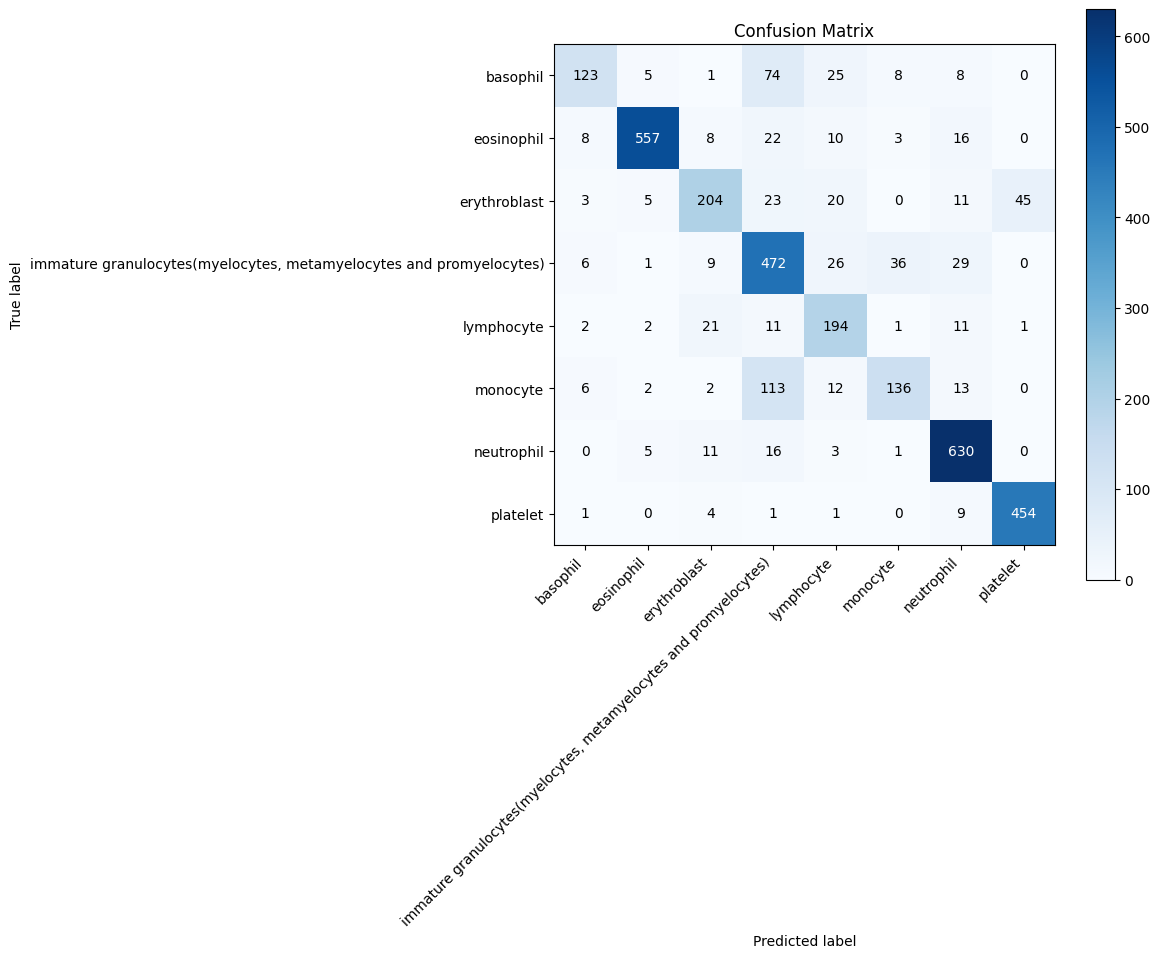

In [26]:
cm = confusion_matrix_plot(model, test_loader_deit, class_names=class_names, device=device)

# **Fine Tuning on Classifier Head + Last 2 Layers**

In [29]:
# Build model
model = build_deit(num_classes, device)

# freeze all layers
for p in model.parameters():
    p.requires_grad = False

# unfreeze head + 2 last layer blocks
for p in model.head.parameters():
    p.requires_grad = True
for p in model.blocks[-1].parameters():   # last block
    p.requires_grad = True
for p in model.blocks[-2].parameters():   # second last block
    p.requires_grad = True

train_loader_deit_16 = DataLoader(train_dataset_deit, batch_size=16, shuffle=True,  num_workers=2, pin_memory=True)
val_loader_deit_16 = DataLoader(val_dataset_deit, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

# Sample shape check
xb, yb = next(iter(train_loader_deit_16))
print("DeiT batch:", xb.shape)

DeiT batch: torch.Size([16, 3, 224, 224])


In [30]:
optimizer = optim.Adam([{"params": model.head.parameters(), "lr": 1e-3}, {"params": model.blocks[-1].parameters(), "lr": 1e-4}, {"params": model.blocks[-2].parameters(), "lr": 1e-4}])
hist15 = train_model(model=model, train_loader=train_loader_deit_16, val_loader=val_loader_deit_16, epochs=10, device=device, optimizer=optimizer, patience=5)

Epoch 01/10 | Train acc: 0.6462 - Train loss: 0.9648 | Val acc: 0.8032 - Val loss: 0.5198
Epoch 02/10 | Train acc: 0.7374 - Train loss: 0.7104 | Val acc: 0.8271 - Val loss: 0.4471
Epoch 03/10 | Train acc: 0.7614 - Train loss: 0.6579 | Val acc: 0.8306 - Val loss: 0.4324
Epoch 04/10 | Train acc: 0.7753 - Train loss: 0.6151 | Val acc: 0.8849 - Val loss: 0.3390
Epoch 05/10 | Train acc: 0.7869 - Train loss: 0.5893 | Val acc: 0.8867 - Val loss: 0.3144
Epoch 06/10 | Train acc: 0.7995 - Train loss: 0.5510 | Val acc: 0.8803 - Val loss: 0.3329
Epoch 07/10 | Train acc: 0.8042 - Train loss: 0.5434 | Val acc: 0.8943 - Val loss: 0.2937
Epoch 08/10 | Train acc: 0.8092 - Train loss: 0.5243 | Val acc: 0.8989 - Val loss: 0.2879
Epoch 09/10 | Train acc: 0.8129 - Train loss: 0.5156 | Val acc: 0.9019 - Val loss: 0.2702
Epoch 10/10 | Train acc: 0.8174 - Train loss: 0.5052 | Val acc: 0.8937 - Val loss: 0.2891

Training finished. Best epoch: 9


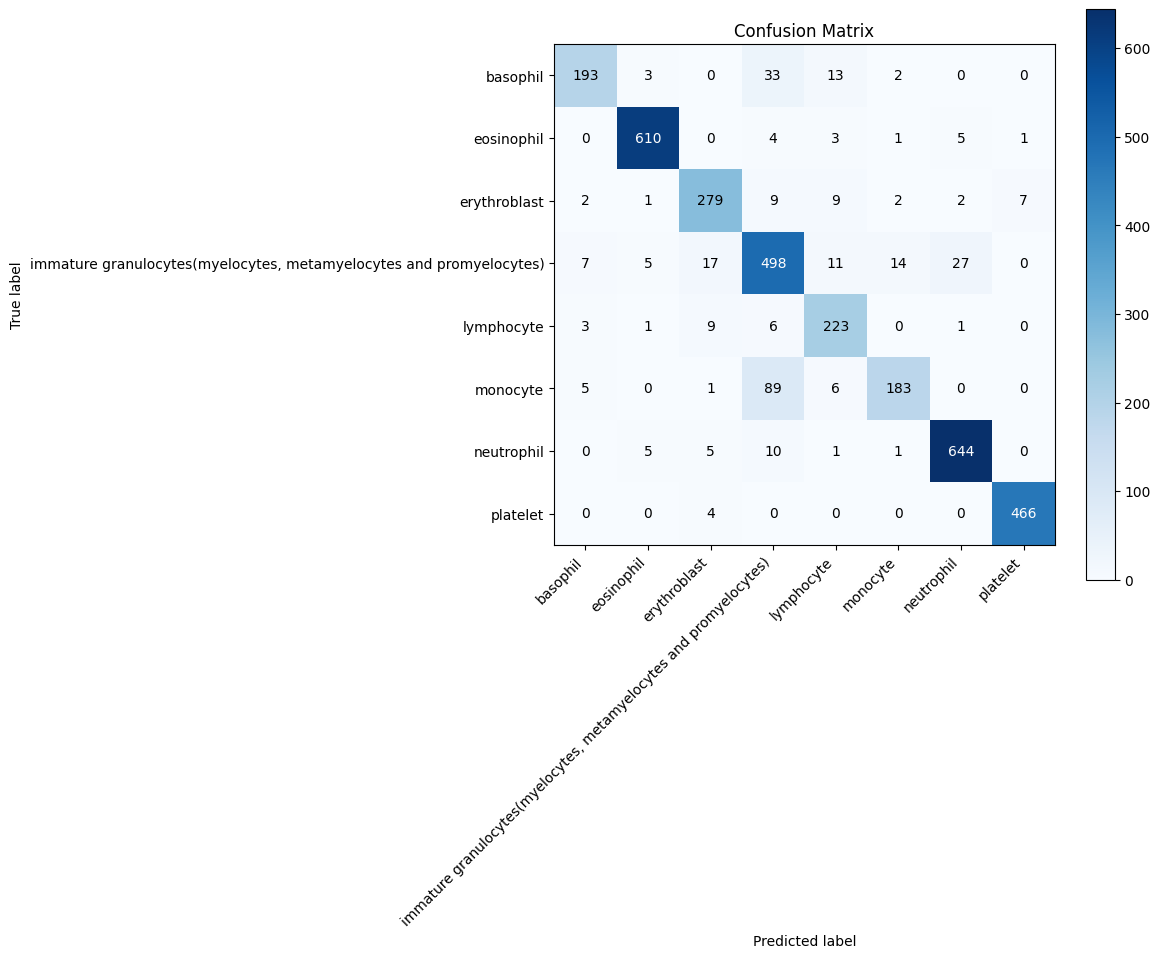

In [31]:
cm = confusion_matrix_plot(model, test_loader_deit, class_names=class_names, device=device)

In [32]:
test_acc = evaluate_accuracy(model, test_loader_deit, device)
print("Test accuracy:", test_acc)

Test accuracy: 0.9049985384390529


# **Learning Curves - Loss**

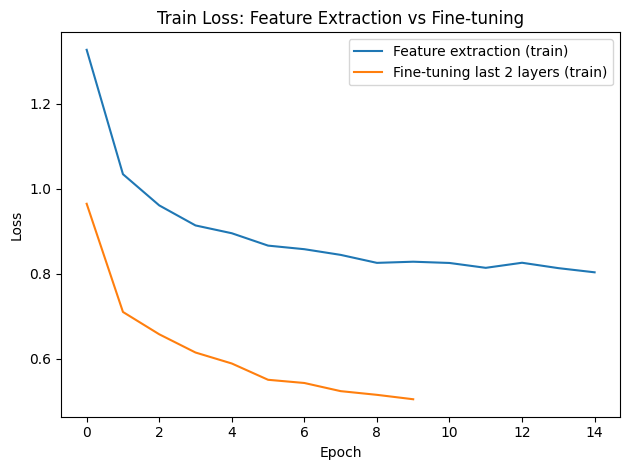

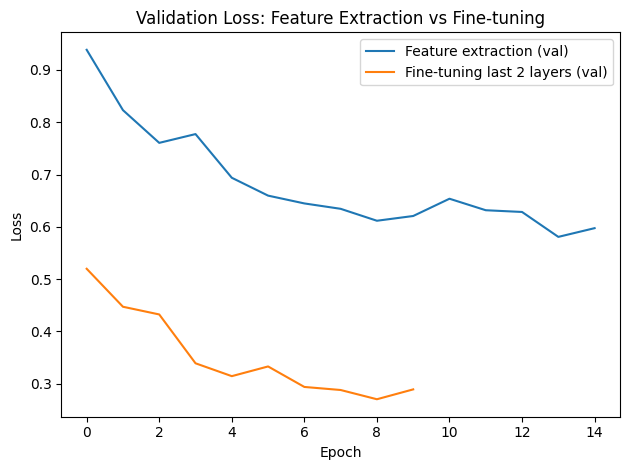

In [33]:
# Train Loss
plt.figure()
plt.plot(hist14["train_loss"], label="Feature extraction (train)")
plt.plot(hist15["train_loss"], label="Fine-tuning last 2 layers (train)")
plt.title("Train Loss: Feature Extraction vs Fine-tuning")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# Val Loss
plt.figure()
plt.plot(hist14["val_loss"], label="Feature extraction (val)")
plt.plot(hist15["val_loss"], label="Fine-tuning last 2 layers (val)")
plt.title("Validation Loss: Feature Extraction vs Fine-tuning")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()


# **Learning Curves - Accuracy**

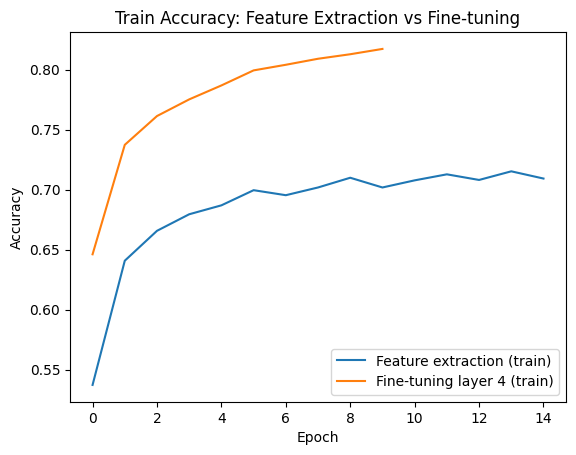

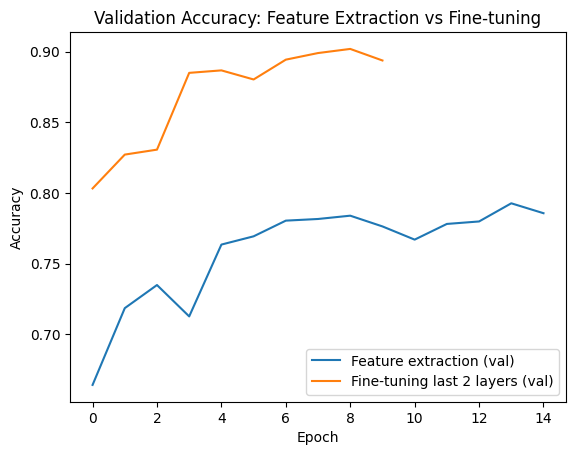

In [36]:
# Train Accuracy
plt.figure()
plt.plot(hist14["train_acc"], label="Feature extraction (train)")
plt.plot(hist15["train_acc"], label="Fine-tuning layer 4 (train)")
plt.title("Train Accuracy: Feature Extraction vs Fine-tuning")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Val Accuracy
plt.figure()
plt.plot(hist14["val_acc"], label="Feature extraction (val)")
plt.plot(hist15["val_acc"], label="Fine-tuning last 2 layers (val)")
plt.title("Validation Accuracy: Feature Extraction vs Fine-tuning")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()